In [1]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn import svm
import json
import numpy as np
import shap
import tensorflow as tf
from random import random


c:\Users\ga84cib\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from pathlib import Path
import ray
from ray.rllib.policy.policy import Policy
from ray.rllib.algorithms.algorithm import Algorithm
from ray.rllib.examples.env.AmelioratingInventoryPOM import AmelioratingInventoryEnv as env
import ray.rllib.algorithms.apo as apo
from ray.tune.registry import register_env, register_trainable
from ray.rllib.utils.checkpoints import get_checkpoint_info

import scipy.stats as st


problem_id = "spirits_012"

path_json = Path(f"C:\\Users\\ga84cib\\Documents\\gitlab\\ameliorating_inventory_drl\\problem_configurations\\{problem_id}\\config.json") 
with open(path_json, 'r') as f:
    JSON_config = json.load(f)

price_mean = JSON_config["price_mean"]
price_std = JSON_config["price_std"]
price_truncation = JSON_config["price_truncation"]
priceDistribution = st.truncnorm(loc=price_mean, scale=price_std, a=(-price_truncation/price_std), b=(price_truncation/price_std))

demandDistributions = [st.norm(loc=JSON_config["demand_means"][i], scale=JSON_config["demand_covs"][i]*JSON_config["demand_means"][i]) for i in range(JSON_config["nProducts"])]
salesPriceDistributions = [st.norm(loc=JSON_config["sales_means"][i], scale=JSON_config["sales_covs"][i]*JSON_config["sales_means"][i]) for i in range(JSON_config["nProducts"])]
correlation_demand_salesprice = JSON_config["correlation_demand_salesprice"]
cov_dem_sp = [correlation_demand_salesprice[p]*demandDistributions[p].std()*salesPriceDistributions[p].std() for p in range(JSON_config["nProducts"])]
demand_salesprice_distribution = [st.multivariate_normal(mean=[demandDistributions[p].mean(), salesPriceDistributions[p].mean()], cov=[[demandDistributions[p].var(), cov_dem_sp[p]], [cov_dem_sp[p], salesPriceDistributions[p].var()]]) for p in range(JSON_config["nProducts"])] #type: ignore
salvage = {p: lambda d, gamma, p=p: JSON_config["salvage_range"][0] + ((demandDistributions[p].cdf(d) - salesPriceDistributions[p].cdf(gamma) + 1)/2) * (JSON_config["salvage_range"][1] - JSON_config["salvage_range"][0]) for p in range(JSON_config["nProducts"])} 

production_step_size_lp = 0.1
production_levels = {p: [round(i,2) for i in np.arange(0,demandDistributions[p].ppf(JSON_config["max_ppf"])+JSON_config["production_step_size"],JSON_config["production_step_size"])] for p in range(JSON_config["nProducts"])}
upper_bound = {"max_reward":JSON_config["upper_bound"]["max_reward"], "inventory_position":np.array(JSON_config["upper_bound"]["inventory_position"])}
expected_revenue = {p: {l: JSON_config["expected_revenue"][str(p)][str(l)] for l in production_levels[p]} for p in range(JSON_config["nProducts"])}
slope = {p: {l: JSON_config["slope"][str(p)][str(l)] for l in production_levels[p]} for p in range(JSON_config["nProducts"])}

horizon = 5000
# Take applicable settings from the JSON file
AIE_config = {"numAges":JSON_config["numAges"], "nProducts":JSON_config["nProducts"], "targetAges":JSON_config["targetAges"],"ageRange":JSON_config["ageRange"], "maxInventory":JSON_config["maxInventory"], "evaporation":JSON_config["evaporation"], 
            "demandDistributions":demandDistributions, "priceDistribution":priceDistribution, "decay_mean":JSON_config["decay_mean"], "decay_cov":JSON_config["decay_cov"], "demand_salesprice_distribution":demand_salesprice_distribution,
            "salesPriceDistributions":salesPriceDistributions, "correlation_demand_salesprice":correlation_demand_salesprice, "brandContributions":JSON_config["sales_means"],
            "holdingCosts":JSON_config["holdingCosts"], "decaySalvage":JSON_config["decaySalvage"], "salvage":salvage, "expected_revenue":expected_revenue, "slope":slope,
            "min_ppf":JSON_config["min_ppf"], "max_ppf":JSON_config["max_ppf"], "production_step_size":JSON_config["production_step_size"], "production_step_size_lp":production_step_size_lp, "upper_bound":upper_bound,
            "allowBlending": JSON_config["allowBlending"], "blendingRange":None, "drl_for_production": False, "products_using_drl":None, "reward_lb":-1.0, "reward_ub":1.0,
            "action_space_design":"box_continuous", "use_adversarial_sampling":False, "render_mode":'rgb_array', "horizon":horizon, "simulate_heuristic":False,
            "use_issuance_model":True, "penalty_structure":0.00001, "history_length":JSON_config["numAges"], "penalty_heuristic_deviation":0}  


if AIE_config["simulate_heuristic"]:
    run_id = "lp_only"
else:
    blending_setting = "full" if AIE_config["blendingRange"] is None else AIE_config["blendingRange"]
    nn_setting = "p" if not AIE_config["drl_for_production"] else "py"+"".join([str(p) for p in AIE_config["products_using_drl"]]) 
    lp_setting = "xy" if not AIE_config["drl_for_production"] else "xy"+"".join([str(p) for p in range(JSON_config["nProducts"]) if p not in AIE_config["products_using_drl"]])
    run_id = f"{blending_setting}_blending_{nn_setting}_nn_{lp_setting}_lp_default_normalization"
storage_path = Path(f"C:\\Users\\ga84cib\\Documents\\gitlab\\ameliorating_inventory_drl\\problem_configurations\\{problem_id}\\training_results\\{run_id}")
regression_file = Path(f"C:\\Users\\ga84cib\\Documents\\gitlab\\ameliorating_inventory_drl\\problem_configurations\\{problem_id}\\training_results\\{run_id}\\regression_data.json")
if regression_file.is_file():
    #load regression data from file
    with open(regression_file, 'r') as f:
        regression_data = json.load(f)
    features = np.array(regression_data["features"])
    responses = np.array(regression_data["responses"])
    rewards = np.array(regression_data["rewards"])
else:
    ray.init(ignore_reinit_error=True)
    register_trainable("APO", apo.APO)
    data_size = 50_000
    register_env("AmelioratingInventory", lambda config: env(config))
    test_env = env(AIE_config)
    if AIE_config["simulate_heuristic"]:
        features, responses, rewards = test_env.simulate_data_for_regression(None, data_size=data_size)
    else:
        with open(storage_path / "best_checkpoint.json", 'r') as f:
            best_checkpoint = json.load(f) 
        print(best_checkpoint)   
        algorithm_path = best_checkpoint["eval"][-1][1] 
        checkpoint_info = get_checkpoint_info(algorithm_path)
        #raise ValueError(f"Checkpoint info: {checkpoint_info}")
        state = Algorithm._checkpoint_info_to_algorithm_state(
            checkpoint_info = checkpoint_info,
            policy_ids = None,
            policy_mapping_fn=None,
            policies_to_train=None,
        )
        state["config"]["num_workers"] = 1
        policy = Algorithm.from_state(state)
        print("Policy loaded")
        #Algorithm.from_checkpoint(algorithm_path, policy_ids=["default_policy"])
        features, responses, rewards = test_env.simulate_data_for_regression(policy, data_size=data_size)
    regression_data = {"features":features.tolist(), "responses":responses.tolist(), "rewards":rewards.tolist()}
    with open(storage_path / "regression_data.json", 'w') as f:
        json.dump(regression_data, f)


2024-07-31 21:45:20,766	INFO worker.py:1553 -- Started a local Ray instance.


SALES BOUND:  [27.59, 19.31, 13.79]
MAX REWARD:  2018.037972361835
MIN_REWARD:  0
Set parameter Username
Academic license - for non-commercial use only - expires 2025-04-17
starting inventory:  [24.54236883 23.84291132 23.19736449 15.5875257  15.20664159  7.327189
  7.16560429  0.          0.          0.        ]
11
10
3
6721
330


WARN: Box bound precision lowered by casting to float32


{'reward_estimate': [[0.08916077750255288, 'C:/Users/ga84cib/Documents/gitlab/ameliorating_inventory_drl/problem_configurations/spirits_012/training_results/full_blending_p_nn_xy_lp_default_normalization\\checkpoint_000169'], [0.08916917056481274, 'C:/Users/ga84cib/Documents/gitlab/ameliorating_inventory_drl/problem_configurations/spirits_012/training_results/full_blending_p_nn_xy_lp_default_normalization\\checkpoint_000144'], [0.08927944784624141, 'C:/Users/ga84cib/Documents/gitlab/ameliorating_inventory_drl/problem_configurations/spirits_012/training_results/full_blending_p_nn_xy_lp_default_normalization\\checkpoint_000115']], 'avg_reward': [[466.92798075533983, 'C:/Users/ga84cib/Documents/gitlab/ameliorating_inventory_drl/problem_configurations/spirits_012/training_results/full_blending_p_nn_xy_lp_default_normalization\\checkpoint_000147'], [466.959402704533, 'C:/Users/ga84cib/Documents/gitlab/ameliorating_inventory_drl/problem_configurations/spirits_012/training_results/full_blendi

2024-07-31 21:45:37,305	INFO algorithm_config.py:2888 -- Executing eagerly (framework='tf2'), with eager_tracing=tf2. For production workloads, make sure to set eager_tracing=True  in order to match the speed of tf-static-graph (framework='tf'). For debugging purposes, `eager_tracing=False` is the best choice.
2024-07-31 21:45:37,699	INFO algorithm.py:506 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.


(RolloutWorker pid=17804) SALES BOUND:  [27.59, 19.31, 13.79]
(RolloutWorker pid=17804) MAX REWARD:  2018.037972361835
(RolloutWorker pid=17804) MIN_REWARD:  0
(RolloutWorker pid=17804) Set parameter Username
(RolloutWorker pid=17804) Academic license - for non-commercial use only - expires 2025-04-17
(RolloutWorker pid=17804) starting inventory:  [24.54236883 23.84291132 23.19736449 15.5875257  15.20664159  7.327189
(RolloutWorker pid=17804)   7.16560429  0.          0.          0.        ]
(RolloutWorker pid=17804) 11
(RolloutWorker pid=17804) 10
(RolloutWorker pid=17804) 3
(RolloutWorker pid=17804) 6721
(RolloutWorker pid=17804) 330


(RolloutWorker pid=17804) c:\Users\ga84cib\AppData\Local\Programs\Python\Python310\lib\site-packages\gymnasium\spaces\box.py:130: UserWarning: WARN: Box bound precision lowered by casting to float32
(RolloutWorker pid=17804)   gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
(RolloutWorker pid=17804) 2024-07-31 21:46:35,529	WARNING env.py:156 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
(RolloutWorker pid=17804) 2024-07-31 21:46:35,531	WARNING env.py:166 -- Your env reset() method appears to take 'seed' or 'return_info' arguments. Note that these are not yet supported in RLlib. Seeding will take place using 'env.seed()' and the info dict will not be returned from reset.


(RolloutWorker pid=17804) FINISH EPISODE
(RolloutWorker pid=17804) FINISH EPISODE


(RolloutWorker pid=17804) c:\Users\ga84cib\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
(RolloutWorker pid=17804)   return _methods._mean(a, axis=axis, dtype=dtype,
(RolloutWorker pid=17804) c:\Users\ga84cib\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
(RolloutWorker pid=17804)   ret = ret.dtype.type(ret / rcount)
Mean of empty slice.
invalid value encountered in divide
2024-07-31 21:46:44,565	INFO trainable.py:172 -- Trainable.setup took 66.943 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
2024-07-31 21:46:44,592	WARNING util.py:67 -- Install gputil for GPU system monitoring.
2024-07-31 21:46:44,697	WARNING eager_tf_policy_v2.py:702 -- Cannot restore an optimizer's state for tf eager! Keras is not able to save the v1.x optimizers (from tf.

Policy loaded
SIMULATING DATA FOR REGRESSION... 999 STEPS COMPLETED
SIMULATING DATA FOR REGRESSION... 1999 STEPS COMPLETED
SIMULATING DATA FOR REGRESSION... 2999 STEPS COMPLETED
SIMULATING DATA FOR REGRESSION... 3999 STEPS COMPLETED
SIMULATING DATA FOR REGRESSION... 4999 STEPS COMPLETED
SIMULATING DATA FOR REGRESSION... 5999 STEPS COMPLETED
SIMULATING DATA FOR REGRESSION... 6999 STEPS COMPLETED
SIMULATING DATA FOR REGRESSION... 7999 STEPS COMPLETED
SIMULATING DATA FOR REGRESSION... 8999 STEPS COMPLETED
SIMULATING DATA FOR REGRESSION... 9999 STEPS COMPLETED
SIMULATING DATA FOR REGRESSION... 10999 STEPS COMPLETED
SIMULATING DATA FOR REGRESSION... 11999 STEPS COMPLETED
SIMULATING DATA FOR REGRESSION... 12999 STEPS COMPLETED
SIMULATING DATA FOR REGRESSION... 13999 STEPS COMPLETED
SIMULATING DATA FOR REGRESSION... 14999 STEPS COMPLETED
SIMULATING DATA FOR REGRESSION... 15999 STEPS COMPLETED
SIMULATING DATA FOR REGRESSION... 16999 STEPS COMPLETED
SIMULATING DATA FOR REGRESSION... 17999 STEPS

In [11]:
print(rewards.mean())
data=regression_data

0.8977589877738269


In [ ]:
problem_ids = ["spirits_002", "spirits_012", "spirits_102", "spirits_112", "spirits_0002", "spirits_0102", "spirits_1002", "spirits_1102", "spirits_002_n", "spirits_012_n", "spirits_102_n", "spirits_112_n", "spirits_0002_n", "spirits_0102_n", "spirits_1002_n", "spirits_1102_n"]
pids_average_blending = ["spirits_002", "spirits_012", "spirits_102", "spirits_112", "spirits_0002", "spirits_0102", "spirits_1002", "spirits_1102"]
pids_minimum_blending = ["spirits_001", "spirits_011", "spirits_101", "spirits_111", "spirits_0001", "spirits_0101", "spirits_1001", "spirits_1101"]
pids_0_blending = ["spirits_000", "spirits_010", "spirits_100", "spirits_110", "spirits_0000", "spirits_0100", "spirits_1000", "spirits_1100"]

data = {}
for problem_id in pids_average_blending+pids_minimum_blending:
    if problem_id in pids_average_blending:
        data_file = f"C:\\Users\\ga84cib\\Documents\\gitlab\\ameliorating_inventory_drl\\problem_configurations\\{problem_id}\\training_results\\full_blending_p_nn_xy_lp_50w\\regression_data.json"
        data_file_0 = f"C:\\Users\\ga84cib\\Documents\\gitlab\\ameliorating_inventory_drl\\problem_configurations\\{problem_id}\\training_results\\0_blending_p_nn_xy_lp\\regression_data.json"
        data[pids_0_blending[pids_average_blending.index(problem_id)]] = json.load(open(data_file_0, "r"))
    else:
        data_file = f"C:\\Users\\ga84cib\\Documents\\gitlab\\ameliorating_inventory_drl\\problem_configurations\\{problem_id}\\training_results\\full_blending_p_nn_xy_lp\\regression_data.json"
    with open(data_file, "r") as f:
        data[problem_id] = json.load(f)

In [36]:
#sales_bound = env(AIE_config).sales_bound
AIE_config = {pid: {"maxInventory": 50 if pid[8]=='0' else 30, "numAges": 10, "nProducts": 3} for pid in pids_average_blending+pids_minimum_blending+pids_0_blending}

label_normalizers = {pid: np.array([AIE_config[pid]["maxInventory"]]*(AIE_config[pid]["numAges"]+AIE_config[pid]["nProducts"]+1)) for pid in pids_average_blending+pids_minimum_blending+pids_0_blending}
#label_normalizers = np.array([AIE_config[pid]["maxInventory"]] + sales_bound + [AIE_config[pid]["maxInventory"]]*AIE_config[pid]["numAges"])

features = {pid: np.array(data[pid]["features"])[:-5000] for pid in pids_average_blending+pids_minimum_blending+pids_0_blending}
labels = {pid: {i: np.array(data[pid]["responses"])[:-5000,i]/label_normalizers[pid][i] for i in range(AIE_config[pid]["numAges"] + AIE_config[pid]["nProducts"] + 1)} for pid in pids_average_blending+pids_minimum_blending+pids_0_blending}
#labels = {i: np.array(data[pid]["responses"])[:-5000,i] for i in range(AIE_config[pid]["numAges"] + AIE_config[pid]["nProducts"] + 1)}

test_features = {pid: np.array(data[pid]["features"])[-5000:] for pid in pids_average_blending+pids_minimum_blending+pids_0_blending}
test_labels = {pid: {i: np.array(data[pid]["responses"])[-5000:,i]/label_normalizers[pid][i] for i in range(AIE_config[pid]["numAges"] + AIE_config[pid]["nProducts"] + 1)} for pid in pids_average_blending+pids_minimum_blending+pids_0_blending}
#test_labels = {i: np.array(data[pid]["responses"])[-5000:,i] for i in range(AIE_config[pid]["numAges"] + AIE_config[pid]["nProducts"] + 1)}

feature_names = ["$\psi$"] +[f"$s_{{{i+1}}}$" for i in range(10)]




In [49]:
#get maximum purchasing amount 
max_purchase = {pid: np.max(labels[pid][0]) for pid in pids_average_blending+pids_minimum_blending+pids_0_blending}
print(max_purchase)

{'spirits_002': 1.0, 'spirits_012': 1.0, 'spirits_102': 1.0, 'spirits_112': 1.0, 'spirits_0002': 1.0, 'spirits_0102': 1.0, 'spirits_1002': 1.0, 'spirits_1102': 1.0, 'spirits_001': 1.0, 'spirits_011': 1.0, 'spirits_101': 1.0, 'spirits_111': 1.0, 'spirits_0001': 1.0, 'spirits_0101': 1.0, 'spirits_1001': 1.0, 'spirits_1101': 1.0, 'spirits_000': 0.8477176427841187, 'spirits_010': 0.8557288646697998, 'spirits_100': 1.0, 'spirits_110': 1.0, 'spirits_0000': 0.9775881767272949, 'spirits_0100': 0.9436706900596619, 'spirits_1000': 1.0, 'spirits_1100': 1.0}


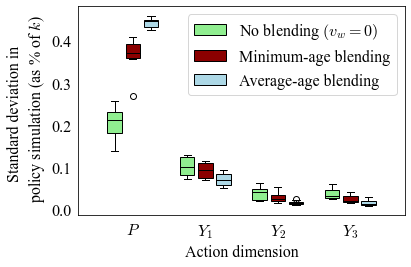

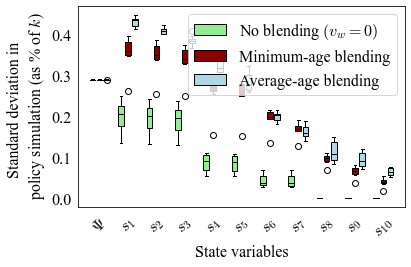

In [6]:
import matplotlib.pyplot as plt

nProducts = 3

# pids_average_blending = ["spirits_0001", "spirits_0101", "spirits_1001", "spirits_1101"]
# pids_average_blending = ["spirits_0102", "spirits_1102", "spirits_0002", "spirits_1002"]
pids_average_blending = ["spirits_002", "spirits_012", "spirits_0002", "spirits_0102", "spirits_102", "spirits_112", "spirits_1002", "spirits_1102"]

# pids_minimum_blending = ["spirits_001", "spirits_011", "spirits_0001", "spirits_0101"]
# pids_minimum_blending = ["spirits_112", "spirits_012", "spirits_102", "spirits_002"]
pids_minimum_blending = ["spirits_001", "spirits_011", "spirits_0001", "spirits_0101", "spirits_101", "spirits_111", "spirits_1001", "spirits_1101"]

#plot stds of labels
stds_average = {i: [np.std(labels[pid][i]) for pid in pids_average_blending] for i in range(11)}
stds_minimum = {i: [np.std(labels[pid][i]) for pid in pids_minimum_blending] for i in range(nProducts + 1)}
stds_0 = {i: [np.std(labels[pid][i]) for pid in pids_0_blending] for i in range(nProducts + 1)}
action_dimensions = ["$P$", "$Y_1$", "$Y_2$", "$Y_3$"]


plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["mathtext.fontset"] = "cm"

plt3 = plt.boxplot([stds_0[i] for i in range(nProducts+1)], positions=[i-0.25 for i in range(nProducts+1)], widths=0.2, patch_artist=True)
plt2 = plt.boxplot([stds_minimum[i] for i in range(nProducts+1)], positions=[i for i in range(nProducts+1)], widths=0.2, patch_artist=True)
plt1 = plt.boxplot([stds_average[i] for i in range(nProducts+1)], positions=[i+0.25 for i in range(nProducts+1)], labels=action_dimensions, widths=0.2, patch_artist=True)

for patch in plt1["medians"]+plt2["medians"]+plt3["medians"]:
    patch.set_color("black")
#change color of plt1 to lightblue and plt2 to darkred and plt3 to lightgreen
for patch in plt1["boxes"]:
    patch.set_facecolor("lightblue")
for patch in plt2["boxes"]:
    patch.set_facecolor("darkred")
for patch in plt3["boxes"]:
    patch.set_facecolor("lightgreen")
plt.rcParams["font.size"] = 16
plt.xlabel("Action dimension", fontsize=16)
plt.ylabel("Standard deviation in \n policy simulation (as % of $k$)", fontsize=16)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

#move x-labels to the right by 0.5
plt.gca().xaxis.set_tick_params(width=0)
plt.gca().yaxis.set_tick_params(width=0)
plt.gca().set_xticks([i for i in range(nProducts+1)])
plt.gca().set_xticklabels(action_dimensions)

plt.legend([plt3["boxes"][0], plt2["boxes"][0], plt1["boxes"][0]], ["No blending $(v_w = 0)$", "Minimum-age blending", "Average-age blending"], loc="upper right", fontsize=16)

plt.tight_layout()
plt.savefig("C:\\Users\\ga84cib\\Documents\\gitlab\\ameliorating_inventory_drl\\problem_configurations\\stds_diss.pdf")


plt.show()

#plot inventory variance across different blending strategies
feature_stds_average = {i: [np.std(features[pid][:,i]) for pid in pids_average_blending] for i in range(11)}
feature_stds_minimum = {i: [np.std(features[pid][:,i]) for pid in pids_minimum_blending] for i in range(11)}
feature_stds_0 = {i: [np.std(features[pid][:,i]) for pid in pids_0_blending] for i in range(11)}

plt3 = plt.boxplot([feature_stds_0[i] for i in range(11)], positions=[i-0.25 for i in range(11)], widths=0.2, patch_artist=True)
plt2 = plt.boxplot([feature_stds_minimum[i] for i in range(11)], positions=[i for i in range(11)], widths=0.2, patch_artist=True)
plt1 = plt.boxplot([feature_stds_average[i] for i in range(11)], positions=[i+0.25 for i in range(11)], labels=feature_names, widths=0.2, patch_artist=True)

for patch in plt1["medians"]+plt2["medians"]+plt3["medians"]:
    patch.set_color("black")
#change color of plt1 to lightblue and plt2 to darkred and plt3 to lightgreen
for patch in plt1["boxes"]:
    patch.set_facecolor("lightblue")
for patch in plt2["boxes"]:
    patch.set_facecolor("darkred")
for patch in plt3["boxes"]:
    patch.set_facecolor("lightgreen")
plt.rcParams["font.size"] = 16
plt.xlabel("State variables", fontsize=16)
plt.ylabel("Standard deviation in \n policy simulation (as % of $k$)", fontsize=16)


plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

#move x-labels to the right by 0.5
plt.gca().xaxis.set_tick_params(width=0)
plt.gca().yaxis.set_tick_params(width=0)
plt.gca().set_xticks([i for i in range(11)])
plt.gca().set_xticklabels(feature_names, rotation=45)

plt.legend([plt3["boxes"][0], plt2["boxes"][0], plt1["boxes"][0]], ["No blending $(v_w = 0)$", "Minimum-age blending", "Average-age blending"], loc="upper right", fontsize=16)

plt.tight_layout()

plt.savefig("C:\\Users\\ga84cib\\Documents\\gitlab\\ameliorating_inventory_drl\\problem_configurations\\stds_features_diss.pdf")
plt.show()



FixedFormatter should only be used together with FixedLocator


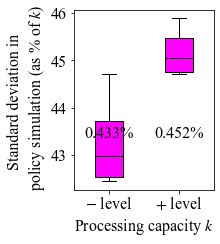

FixedFormatter should only be used together with FixedLocator


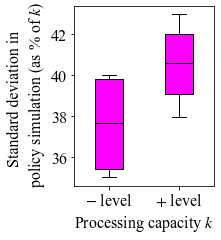

In [25]:
import matplotlib.pyplot as plt



k_plus = ["spirits_002", "spirits_012",  "spirits_0002", "spirits_0102"]#, "spirits_001", "spirits_011",  "spirits_0001", "spirits_0101"]
k_minus = ["spirits_102", "spirits_112", "spirits_1002", "spirits_1102"]#, "spirits_101", "spirits_111", "spirits_1001", "spirits_1101"]

#plot stds of k_minus and k_plus only for action dimension 0
stds_minus = {i: [np.std(labels[pid][i]) for pid in k_minus] for i in range(nProducts + 1)}
stds_plus = {i: [np.std(labels[pid][i]) for pid in k_plus] for i in range(nProducts + 1)}

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["mathtext.fontset"] = "stix"

#boxplot for k_minus on the left and k_plus on the right
plt.figure(figsize=(2.5,3.3))
plt2 = plt.boxplot([stds_minus[0]], positions=[0], widths=0.4, patch_artist=True)
plt1 = plt.boxplot([stds_plus[0]], positions=[1], widths=0.4, patch_artist=True)


for patch in plt1["medians"]+plt2["medians"]:
    patch.set_color("black")
#change colors to magenta
for patch in plt1["boxes"]:
    patch.set_facecolor("magenta")
for patch in plt2["boxes"]:
    patch.set_facecolor("magenta")
plt.rcParams["font.size"] = 16
plt.xlabel("Processing capacity $k$", fontsize=16)
plt.ylabel("Standard deviation in \n policy simulation (as % of $k$)", fontsize=16)
#set y tick labels to percentages
plt.gca().set_yticklabels([f"{round(i*100)}" for i in plt.gca().get_yticks()])

#change size of ticks
plt.xticks(fontsize=16) 
plt.yticks(fontsize=16)
plt.gca().set_xticklabels(["$-$ level", "$+$ level"])

#add text for mean values
for i in range(2):
    plt.text(i, np.mean(stds_minus[0 if i==1 else 0]), f"{round(np.mean(stds_minus[0]) if i==0 else np.mean(stds_plus[0]),ndigits=3)}%", ha="center", va="bottom", fontsize=16)


plt.savefig("C:\\Users\\ga84cib\\Documents\\gitlab\\ameliorating_inventory_drl\\problem_configurations\\stds_k.pdf")

plt.show()

k_plus = [ "spirits_001", "spirits_011",  "spirits_0001", "spirits_0101"]
k_minus = [ "spirits_101", "spirits_111", "spirits_1001", "spirits_1101"]

#plot stds of k_minus and k_plus only for action dimension 0
stds_minus = {i: [np.std(labels[pid][i]) for pid in k_minus] for i in range(nProducts + 1)}
stds_plus = {i: [np.std(labels[pid][i]) for pid in k_plus] for i in range(nProducts + 1)}

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["mathtext.fontset"] = "stix"

#boxplot for k_minus on the left and k_plus on the right
plt.figure(figsize=(2.5,3.3))
plt2 = plt.boxplot([stds_minus[0]], positions=[0], widths=0.4, patch_artist=True)
plt1 = plt.boxplot([stds_plus[0]], positions=[1], widths=0.4, patch_artist=True)


for patch in plt1["medians"]+plt2["medians"]:
    patch.set_color("black")
#change colors to magenta
for patch in plt1["boxes"]:
    patch.set_facecolor("magenta")
for patch in plt2["boxes"]:
    patch.set_facecolor("magenta")
plt.rcParams["font.size"] = 16
plt.xlabel("Processing capacity $k$", fontsize=16)
plt.ylabel("Standard deviation in \n policy simulation (as % of $k$)", fontsize=16)
#set y tick labels to percentages
plt.gca().set_yticklabels([f"{round(i*100)}" for i in plt.gca().get_yticks()])

#change size of ticks
plt.xticks(fontsize=16) 
plt.yticks(fontsize=16)
plt.gca().set_xticklabels(["$-$ level", "$+$ level"])

plt.savefig("C:\\Users\\ga84cib\\Documents\\gitlab\\ameliorating_inventory_drl\\problem_configurations\\stds_k_min.pdf")

plt.show()



Average issuance age: {'spirits_002': 5.13550714187306, 'spirits_012': 5.060150963439318, 'spirits_0002': 5.127788246988434, 'spirits_0102': 5.0839891392613294, 'spirits_102': 5.498597542122328, 'spirits_112': 5.320935157428179, 'spirits_1002': 5.5336718493081305, 'spirits_1102': 5.405000678733919}
Average target age: {'spirits_002': 5.13175709265607, 'spirits_012': 5.052508538978891, 'spirits_0002': 5.118314202744698, 'spirits_0102': 5.0721482293971425, 'spirits_102': 5.498597542122874, 'spirits_112': 5.320934521768751, 'spirits_1002': 5.5336163581755695, 'spirits_1102': 5.4049722562270315}
Average target age excess average: {'spirits_002': 0.003750049216989737, 'spirits_012': 0.007642424460426511, 'spirits_0002': 0.009474044243735769, 'spirits_0102': 0.011840909864186955, 'spirits_102': -5.46229728115577e-13, 'spirits_112': 6.356594282053152e-07, 'spirits_1002': 5.5491132560980816e-05, 'spirits_1102': 2.8422506887615384e-05}
Average target age excess minimum: {'spirits_001': 0.384564

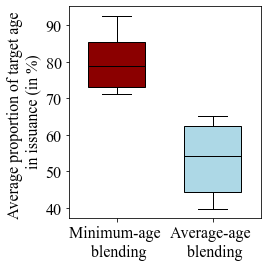

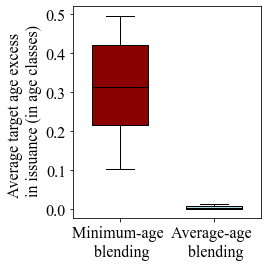

In [7]:
#get average target age excess from data
target_ages = [2,4,6]
evaporation = {pid: 0.02 if pid[9] == "1" else 0.03 for pid in pids_average_blending+pids_minimum_blending+pids_0_blending}
evaporation_remains_age = {pid: [pow((1-evaporation[pid]),(i)) for i in range(AIE_config[pid]["numAges"])] for pid in pids_average_blending+pids_minimum_blending+pids_0_blending}
issuance = {pid: {i: np.array(labels[pid][i+4]) for i in range(AIE_config[pid]["numAges"])} for pid in pids_average_blending+pids_minimum_blending+pids_0_blending}
production = {pid: {i: np.array(labels[pid][i+1]) for i in range(len(target_ages))} for pid in pids_average_blending+pids_minimum_blending+pids_0_blending}


issuance_ages = {pid: sum(sum(issuance[pid][i]*(i+1)*evaporation_remains_age[pid][i]) for i in range(AIE_config[pid]["numAges"]))/sum(sum(issuance[pid][i]*evaporation_remains_age[pid][i]) for i in range(AIE_config[pid]["numAges"])) for pid in pids_average_blending}
print("Average issuance age:", issuance_ages)
production_ages =  {pid: sum(sum(production[pid][i]*(target_ages[i]+1)) for i in range(len(target_ages)))/sum(sum(production[pid][i]) for i in range(len(target_ages))) for pid in pids_average_blending}
print("Average target age:", production_ages)

target_age_excess_average = {pid: sum(sum(issuance[pid][i]*(i+1)*evaporation_remains_age[pid][i]) for i in range(AIE_config[pid]["numAges"]))/sum(sum(issuance[pid][i]*evaporation_remains_age[pid][i]) for i in range(AIE_config[pid]["numAges"])) - sum(sum(production[pid][i]*(target_ages[i]+1)) for i in range(len(target_ages)))/sum(sum(production[pid][i]) for i in range(len(target_ages))) for pid in pids_average_blending}

print("Average target age excess average:", target_age_excess_average)

target_age_excess_minimum = {pid: sum(sum(issuance[pid][i]*(i+1)*evaporation_remains_age[pid][i]) for i in range(AIE_config[pid]["numAges"]))/sum(sum(issuance[pid][i]*evaporation_remains_age[pid][i]) for i in range(AIE_config[pid]["numAges"])) - sum(sum(production[pid][i]*(target_ages[i]+1)) for i in range(len(target_ages)))/sum(sum(production[pid][i]) for i in range(len(target_ages))) for pid in pids_minimum_blending}

print("Average target age excess minimum:", target_age_excess_minimum)

#calculate standard deviation for every age class in issuance vectors for each problem
mean_issuance = {pid: [np.mean(issuance[pid][i]*evaporation_remains_age[pid][i]) for i in range(AIE_config[pid]["numAges"])] for pid in pids_average_blending+pids_minimum_blending+pids_0_blending}
stds_issuance = {pid: [np.std(issuance[pid][i]*evaporation_remains_age[pid][i]) for i in range(AIE_config[pid]["numAges"])] for pid in pids_average_blending+pids_minimum_blending+pids_0_blending}

proportion_target_age = {pid: sum(sum(issuance[pid][i]*evaporation_remains_age[pid][i+1]) for i in target_ages)/sum(sum(production[pid][i]) for i in range(len(target_ages))) for pid in pids_average_blending+pids_minimum_blending+pids_0_blending}

print("Average proportion of target age in issuance:", proportion_target_age)

#create two plots, one showing the proportion of target age in issuance and the other showing the average target age excess
#plot proportion of target age in issuance in boxplot for average and minimum blending according to color scheme
#figure should be small size on horizontal axis
plt.figure(figsize=(4,4))
plt1 = plt.boxplot([proportion_target_age[pid] for pid in pids_average_blending], positions=[1], widths=0.6, patch_artist=True)
plt2 = plt.boxplot([proportion_target_age[pid] for pid in pids_minimum_blending], positions=[0], widths=0.6, patch_artist=True)

for patch in plt1["medians"]+plt2["medians"]:
    patch.set_color("black")
#change color of plt1 to lightblue and plt2 to darkred
for patch in plt1["boxes"]:
    patch.set_facecolor("lightblue")
for patch in plt2["boxes"]:
    patch.set_facecolor("darkred")
plt.rcParams["font.size"] = 16
plt.xticks([0,1], ["Minimum-age \n blending", "Average-age \n blending"], fontsize=16)
plt.ylabel("Average proportion of target age \n in issuance (in %)", fontsize=16)
plt.yticks([0.4,0.5,0.6,0.7,0.8,0.9], [f"{int(i*100)}" for i in [0.4,0.5,0.6,0.7,0.8,0.9]])


plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.savefig("C:\\Users\\ga84cib\\Documents\\gitlab\\ameliorating_inventory_drl\\problem_configurations\\proportion_target_age_diss.pdf")
plt.show()


#plot target age excess in boxplot for average and minimum blending according to color scheme
plt.figure(figsize=(4,4))
plt1 = plt.boxplot([list(target_age_excess_average.values())], positions=[1], widths=0.6, patch_artist=True)
plt2 = plt.boxplot([list(target_age_excess_minimum.values())], positions=[0], widths=0.6, patch_artist=True)

for patch in plt1["medians"]+plt2["medians"]:
    patch.set_color("black")
#change color of plt1 to lightblue and plt2 to darkred
for patch in plt1["boxes"]:
    patch.set_facecolor("lightblue")
for patch in plt2["boxes"]:
    patch.set_facecolor("darkred")
plt.rcParams["font.size"] = 16
plt.xticks([0,1], ["Minimum-age \n blending", "Average-age \n blending"], fontsize=16)
plt.ylabel("Average target age excess \n in issuance (in age classes)", fontsize=16)
plt.rcParams["grid.linestyle"] = ""

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.savefig("C:\\Users\\ga84cib\\Documents\\gitlab\\ameliorating_inventory_drl\\problem_configurations\\target_age_excess_diss.pdf")
plt.show()




# numAges = 10
# #plot mean of issuance vectors for each age class as boxplots over problems pertaining for average blending (10 boxplots, 1 per age class) colored in lightblue
# plt.figure()
# plts1 = {}
# plts2 = {}	
# for i in range(numAges):
#     plts1[i] = plt.boxplot([mean_issuance[pid][i] for pid in pids_average_blending], positions=[i-0.2], widths=0.4, patch_artist=True)
#     plts2[i] = plt.boxplot([mean_issuance[pid][i] for pid in pids_minimum_blending], positions=[i+0.2], widths=0.4, patch_artist=True)
#     for patch in plts1[i]["boxes"]:
#         patch.set_facecolor("lightblue")
#     for patch in plts2[i]["boxes"]:
#         patch.set_facecolor("darkred")
#     for patch in plts1[i]["medians"]+plts2[i]["medians"]:
#         patch.set_color("black")

# plt.xticks([i for i in range(numAges)], [f"{i+1}" for i in range(numAges)], fontsize=16)
# plt.yticks(fontsize=16)
# plt.ylabel("Mean of issuance vector", fontsize=16)
# plt.xlabel("Age class", fontsize=16)
# #place legend outside of plot
# plt.legend([plts1[0]["boxes"][0], plts2[0]["boxes"][0]], ["Average-age blending", "Minimum-age blending"], loc="upper right", fontsize=16)


# plt.tight_layout()
# plt.savefig("C:\\Users\\ga84cib\\Documents\\gitlab\\ameliorating_inventory_drl\\problem_configurations\\mean_issuance.pdf")
# plt.show()

# #plot mean of issuance vectors for each age class as boxplots over problems pertaining for average blending (10 boxplots, 1 per age class) colored in lightblue
# plt.figure()
# plts = {}
# for i in range(numAges):
#     plts[i] = plt.boxplot([mean_issuance[pid][i] for pid in pids_minimum_blending], positions=[i], widths=0.7, patch_artist=True)
#     for patch in plts[i]["boxes"]:
#         patch.set_facecolor("darkred")
#     for patch in plts[i]["medians"]:
#         patch.set_color("black")

# plt.xticks([i for i in range(numAges)], [f"{i+1}" for i in range(numAges)], fontsize=16)
# plt.yticks(fontsize=16)
# plt.ylabel("Mean of issuance vector", fontsize=16)
# plt.xlabel("Age class", fontsize=16)
# plt.tight_layout()
# plt.savefig("C:\\Users\\ga84cib\\Documents\\gitlab\\ameliorating_inventory_drl\\problem_configurations\\mean_issuance_minimum.pdf")
# plt.show()




In [386]:
problem_ids = pids_average_blending 
tree = {}
model = {}
polynomial = {}
depths = [5, 10, 15, 20, 25]
for pid in problem_ids:
    print("Problem ID: ", pid)
    predictor[pid] = {}
    tree[pid] = {}
    for depth in depths:
        print("Depth: ", depth)
        #create a decision tree predictor
        predictor[pid][depth] = {i: DecisionTreeRegressor(max_depth=depth) for i in range(AIE_config[pid]["numAges"] + AIE_config[pid]["nProducts"] + 1)}
        tree[pid][depth] = {i: predictor[pid][depth][i].fit(features[pid], labels[pid][i]) for i in range(AIE_config[pid]["numAges"] + AIE_config[pid]["nProducts"] + 1)}


    # #create a linear regression predictor 
    # linear_predictor = {i: LinearRegression() for i in range(AIE_config[pid]["numAges"] + AIE_config[pid]["nProducts"] + 1)}
    # linear = {i: linear_predictor[i].fit(features, labels[i]) for i in range(AIE_config[pid]["numAges"] + AIE_config[pid]["nProducts"] + 1)}

    model[pid] = {} 
    polynomial[pid] = {}
    for i in range(AIE_config[pid]["numAges"] + AIE_config[pid]["nProducts"] + 1):
        print(i)
        model[pid][i] = Pipeline([
        ('poly', PolynomialFeatures(degree=5)),
        ('linear', LinearRegression(fit_intercept=True))
        ])
        polynomial[pid][i] = model[pid][i].fit(features[pid], labels[pid][i])
     



Problem ID:  spirits_002
Depth:  5
Depth:  10
Depth:  15
Depth:  20
Depth:  25
Problem ID:  spirits_012
Depth:  5
Depth:  10
Depth:  15
Depth:  20
Depth:  25
Problem ID:  spirits_102
Depth:  5
Depth:  10
Depth:  15
Depth:  20
Depth:  25
Problem ID:  spirits_112
Depth:  5
Depth:  10
Depth:  15
Depth:  20
Depth:  25
Problem ID:  spirits_0002
Depth:  5
Depth:  10
Depth:  15
Depth:  20
Depth:  25
Problem ID:  spirits_0102
Depth:  5
Depth:  10
Depth:  15
Depth:  20
Depth:  25
Problem ID:  spirits_1002
Depth:  5
Depth:  10
Depth:  15
Depth:  20
Depth:  25
Problem ID:  spirits_1102
Depth:  5
Depth:  10
Depth:  15
Depth:  20
Depth:  25


In [387]:
import pickle
#save the models
for pid in pids_average_blending:#+pids_minimum_blending:
    # with open(f"C:\\Users\\ga84cib\\Documents\\gitlab\\ameliorating_inventory_drl\\problem_configurations\\{pid}\\training_results\\0_blending_p_nn_xy_lp_50w\\polynomial5.pkl", "wb") as f:
    #     pickle.dump(polynomial[pid], f)
    with open(f"C:\\Users\\ga84cib\\Documents\\gitlab\\ameliorating_inventory_drl\\problem_configurations\\{pid}\\training_results\\full_blending_p_nn_xy_lp_50w\\tree5.pkl", "wb") as f:
        pickle.dump(tree[pid][5], f)
    with open(f"C:\\Users\\ga84cib\\Documents\\gitlab\\ameliorating_inventory_drl\\problem_configurations\\{pid}\\training_results\\full_blending_p_nn_xy_lp_50w\\tree10.pkl", "wb") as f:
        pickle.dump(tree[pid][10], f)
    with open(f"C:\\Users\\ga84cib\\Documents\\gitlab\\ameliorating_inventory_drl\\problem_configurations\\{pid}\\training_results\\full_blending_p_nn_xy_lp_50w\\tree15.pkl", "wb") as f:
        pickle.dump(tree[pid][15], f)
    with open(f"C:\\Users\\ga84cib\\Documents\\gitlab\\ameliorating_inventory_drl\\problem_configurations\\{pid}\\training_results\\full_blending_p_nn_xy_lp_50w\\tree20.pkl", "wb") as f:
        pickle.dump(tree[pid][20], f)
    with open(f"C:\\Users\\ga84cib\\Documents\\gitlab\\ameliorating_inventory_drl\\problem_configurations\\{pid}\\training_results\\full_blending_p_nn_xy_lp_50w\\tree25.pkl", "wb") as f:
        pickle.dump(tree[pid][25], f)
    # tree[pid] = pickle.load(open(f"C:\\Users\\ga84cib\\Documents\\gitlab\\ameliorating_inventory_drl\\problem_configurations\\{pid}\\training_results\\full_blending_p_nn_xy_lp_50w\\tree25.pkl", "rb"))
    # polynomial[pid] = pickle.load(open(f"C:\\Users\\ga84cib\\Documents\\gitlab\\ameliorating_inventory_drl\\problem_configurations\\{pid}\\training_results\\full_blending_p_nn_xy_lp_50w\\polynomial5.pkl", "rb"))
    #{pids_average_blending[pids_0_blending.index(pid)]}
# for pid in pids_0_blending:
#     with open(f"C:\\Users\\ga84cib\\Documents\\gitlab\\ameliorating_inventory_drl\\problem_configurations\\{pids_average_blending[pids_0_blending.index(pid)]}\\training_results\\0_blending_p_nn_xy_lp\\tree5.pkl", "wb") as f:
#         pickle.dump(tree[pid][5], f)
#     with open(f"C:\\Users\\ga84cib\\Documents\\gitlab\\ameliorating_inventory_drl\\problem_configurations\\{pids_average_blending[pids_0_blending.index(pid)]}\\training_results\\0_blending_p_nn_xy_lp\\tree10.pkl", "wb") as f:
#         pickle.dump(tree[pid][10], f)
#     with open(f"C:\\Users\\ga84cib\\Documents\\gitlab\\ameliorating_inventory_drl\\problem_configurations\\{pids_average_blending[pids_0_blending.index(pid)]}\\training_results\\0_blending_p_nn_xy_lp\\tree15.pkl", "wb") as f:
#         pickle.dump(tree[pid][15], f)
#     with open(f"C:\\Users\\ga84cib\\Documents\\gitlab\\ameliorating_inventory_drl\\problem_configurations\\{pids_average_blending[pids_0_blending.index(pid)]}\\training_results\\0_blending_p_nn_xy_lp\\tree20.pkl", "wb") as f:
#         pickle.dump(tree[pid][20], f)
#     with open(f"C:\\Users\\ga84cib\\Documents\\gitlab\\ameliorating_inventory_drl\\problem_configurations\\{pids_average_blending[pids_0_blending.index(pid)]}\\training_results\\0_blending_p_nn_xy_lp\\tree25.pkl", "wb") as f:
#         pickle.dump(tree[pid][25], f)




In [8]:
#load the models
import pickle
tree5 = {}; tree25 = {}; tree10 = {}; tree15 = {}; tree20 = {}
for pid in pids_average_blending+pids_minimum_blending:
    tree5[pid] = pickle.load(open(f"C:\\Users\\ga84cib\\Documents\\gitlab\\ameliorating_inventory_drl\\problem_configurations\\{pid}\\training_results\\full_blending_p_nn_xy_lp_50w\\tree5.pkl", "rb"))
    tree10[pid] = pickle.load(open(f"C:\\Users\\ga84cib\\Documents\\gitlab\\ameliorating_inventory_drl\\problem_configurations\\{pid}\\training_results\\full_blending_p_nn_xy_lp_50w\\tree10.pkl", "rb"))
    tree20[pid] = pickle.load(open(f"C:\\Users\\ga84cib\\Documents\\gitlab\\ameliorating_inventory_drl\\problem_configurations\\{pid}\\training_results\\full_blending_p_nn_xy_lp_50w\\tree20.pkl", "rb"))
    tree25[pid] = pickle.load(open(f"C:\\Users\\ga84cib\\Documents\\gitlab\\ameliorating_inventory_drl\\problem_configurations\\{pid}\\training_results\\full_blending_p_nn_xy_lp_50w\\tree25.pkl", "rb"))
    # polynomial5[pid] = pickle.load(open(f"C:\\Users\\ga84cib\\Documents\\gitlab\\ameliorating_inventory_drl\\problem_configurations\\{pid}\\training_results\\full_blending_p_nn_xy_lp_50w\\polynomial5.pkl", "rb"))
    tree15[pid] = pickle.load(open(f"C:\\Users\\ga84cib\\Documents\\gitlab\\ameliorating_inventory_drl\\problem_configurations\\{pid}\\training_results\\full_blending_p_nn_xy_lp_50w\\tree15.pkl", "rb"))
    # polynomial3[pid] = pickle.load(open(f"C:\\Users\\ga84cib\\Documents\\gitlab\\ameliorating_inventory_drl\\problem_configurations\\{pid}\\training_results\\full_blending_p_nn_xy_lp_50w\\polynomial3.pkl", "rb"))
for pid in pids_0_blending:
    tree5[pid] = pickle.load(open(f"C:\\Users\\ga84cib\\Documents\\gitlab\\ameliorating_inventory_drl\\problem_configurations\\{pids_average_blending[pids_0_blending.index(pid)]}\\training_results\\0_blending_p_nn_xy_lp\\tree5.pkl", "rb"))
    tree10[pid] = pickle.load(open(f"C:\\Users\\ga84cib\\Documents\\gitlab\\ameliorating_inventory_drl\\problem_configurations\\{pids_average_blending[pids_0_blending.index(pid)]}\\training_results\\0_blending_p_nn_xy_lp\\tree10.pkl", "rb"))
    tree20[pid] = pickle.load(open(f"C:\\Users\\ga84cib\\Documents\\gitlab\\ameliorating_inventory_drl\\problem_configurations\\{pids_average_blending[pids_0_blending.index(pid)]}\\training_results\\0_blending_p_nn_xy_lp\\tree20.pkl", "rb"))
    tree25[pid] = pickle.load(open(f"C:\\Users\\ga84cib\\Documents\\gitlab\\ameliorating_inventory_drl\\problem_configurations\\{pids_average_blending[pids_0_blending.index(pid)]}\\training_results\\0_blending_p_nn_xy_lp\\tree25.pkl", "rb"))
    # polynomial5[pid] = pickle.load(open(f"C:\\Users\\ga84cib\\Documents\\gitlab\\ameliorating_inventory_drl\\problem_configurations\\{pid}\\training_results\\full_blending_p_nn_xy_lp_50w\\polynomial5.pkl", "rb"))
    tree15[pid] = pickle.load(open(f"C:\\Users\\ga84cib\\Documents\\gitlab\\ameliorating_inventory_drl\\problem_configurations\\{pids_average_blending[pids_0_blending.index(pid)]}\\training_results\\0_blending_p_nn_xy_lp\\tree15.pkl", "rb"))
    # polynomial3[pid] = pickle.load(open(f"C:\\Users\\ga84cib\\Documents\\gitlab\\ameliorating_inventory_drl\\problem_configurations\\{pid}\\training_results\\full_blending_p_nn_xy_lp_50w\\polynomial3.pkl", "rb"))

In [ ]:

#load the models
import pickle
tree25 = {}; polynomial5 = {}; tree15 = {}; polynomial3 = {}
for pid in problem_ids:
    tree25[pid] = pickle.load(open(f"C:\\Users\\ga84cib\\Documents\\gitlab\\ameliorating_inventory_drl\\problem_configurations\\{pid}\\training_results\\full_blending_p_nn_xy_lp_50w\\tree25.pkl", "rb"))
    polynomial5[pid] = pickle.load(open(f"C:\\Users\\ga84cib\\Documents\\gitlab\\ameliorating_inventory_drl\\problem_configurations\\{pid}\\training_results\\full_blending_p_nn_xy_lp_50w\\polynomial5.pkl", "rb"))
    tree15[pid] = pickle.load(open(f"C:\\Users\\ga84cib\\Documents\\gitlab\\ameliorating_inventory_drl\\problem_configurations\\{pid}\\training_results\\full_blending_p_nn_xy_lp_50w\\tree15.pkl", "rb"))
    polynomial3[pid] = pickle.load(open(f"C:\\Users\\ga84cib\\Documents\\gitlab\\ameliorating_inventory_drl\\problem_configurations\\{pid}\\training_results\\full_blending_p_nn_xy_lp_50w\\polynomial3.pkl", "rb"))


In [20]:
for pid in problem_ids:
    print("evaluation problem id: ", pid)
    for i in range(AIE_config[pid]["numAges"] + AIE_config[pid]["nProducts"] + 1):
        print(f"Action dimension {i}")
        #check out-of-sample performance of tree
        predictions = polynomial5[pid][i].predict(test_features[pid])
        predictions_tree = tree25[pid][i].predict(test_features[pid])
        #print accuracy
        print("R2: ", polynomial5[pid][i].score(test_features[pid], test_labels[pid][i]))
        print("MSE: ", np.mean((predictions - test_labels[pid][i])**2))
        print("R2 tree: ", tree25[pid][i].score(test_features[pid], test_labels[pid][i]))
        print("MSE tree: ", np.mean((predictions_tree - test_labels[pid][i])**2))
        
        print("COEFFICIENTS: ", len(polynomial5[pid][i].named_steps['linear'].coef_))
        print("INTERCEPT: ", polynomial5[pid][i].named_steps['linear'].intercept_)
        #define feature names in math font
        #plot feature importances
        # import matplotlib.pyplot as plt
        # plt.bar(feature_names, linear_predictor[i].coef_)
        # plt.ylabel("Feature importance")
        # plt.show()
        #print variance of response
        print("Coefficient of variance: ", np.std(test_labels[pid][i])/np.mean(test_labels[pid][i]))
        print("relative MSE: ", np.mean((predictions - test_labels[pid][i])**2)/np.mean((test_labels[pid][i]))**2)
        print("relative MSE tree: ", np.mean((predictions_tree - test_labels[pid][i])**2)/np.mean((test_labels[pid][i]))**2)

evaluation problem id:  spirits_1002
Action dimension 0
R2:  0.9567713582762963
MSE:  0.008660164566377438
R2 tree:  0.9818325529282343
MSE tree:  0.0036395564403350713
COEFFICIENTS:  4368
INTERCEPT:  2.9523951932786883
Coefficient of variance:  0.722957126977602
relative MSE:  0.02259418480575733
relative MSE tree:  0.009495525193964419
Action dimension 1
R2:  0.9133997981436963
MSE:  0.000550494322231095
R2 tree:  0.8049640117664075
MSE tree:  0.0012397916153991967
COEFFICIENTS:  4368
INTERCEPT:  -19.792457884682943
Coefficient of variance:  1.2531989123319405
relative MSE:  0.13600626771798013
relative MSE tree:  0.3063054849959098
Action dimension 2
R2:  0.9420706921797174
MSE:  4.62148402127083e-05
R2 tree:  0.6406658319044307
MSE tree:  0.00028666959413743926
COEFFICIENTS:  4368
INTERCEPT:  2.136939447653115
Coefficient of variance:  0.14027243376232396
relative MSE:  0.0011398376645976606
relative MSE tree:  0.007070386897127589
Action dimension 3
R2:  0.9217544618983592
MSE:  1

In [40]:
#create a plot showing the MSE of the polynomial regression (degree 3 and 5) and the tree regression (depth 15 and 25) as boxplots over the different problem ids for action dimensions 0 - 3 (x-axis)
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
data = []
for pid in pids_average_blending+pids_minimum_blending:
    for i in range(4):
        data.append({"Action dimension": i, "MSE": np.mean((tree15[pid][i].predict(test_features[pid]) - test_labels[pid][i])**2), "model": "Tree (depth 15)", "Problem ID": pid})
        data.append({"Action dimension": i, "MSE": np.mean((polynomial3[pid][i].predict(test_features[pid]) - test_labels[pid][i])**2), "model": "Polynomial (degree 3)", "Problem ID": pid})
        data.append({"Action dimension": i, "MSE": np.mean((tree25[pid][i].predict(test_features[pid]) - test_labels[pid][i])**2), "model": "Tree (depth 25)", "Problem ID": pid})
        data.append({"Action dimension": i, "MSE": np.mean((polynomial5[pid][i].predict(test_features[pid]) - test_labels[pid][i])**2), "model": "Polynomial (degree 5)", "Problem ID": pid})
        
        
df = pd.DataFrame(data)



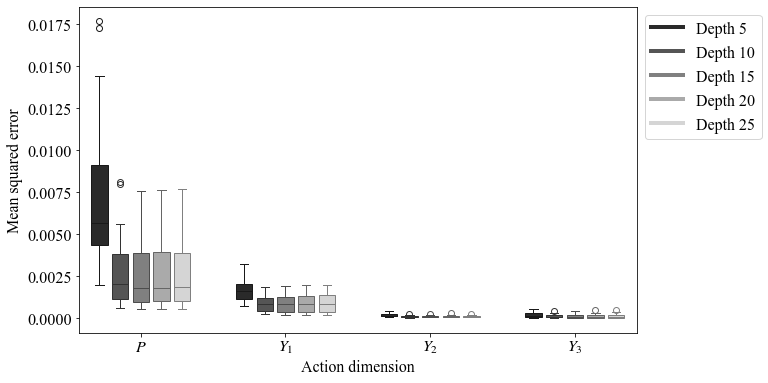

In [41]:
#change math font to stix
from matplotlib import pyplot as plt
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["mathtext.fontset"] = "stix"
plt.rcParams.update({'font.size': 18})
#change plot font size
x_data = ["$P$", "$Y_1$", "$Y_2$", "$Y_3$"]

# Create the figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Define the width of the boxplots and the space between them
width = 0.2
space_between_models = 0.05  # Control this to adjust space between individual boxplots within each group
space_between_groups = 0.5  # Control this to adjust space between groups of boxplots

# Get unique models and action dimensions
unique_models = df['model'].unique()
unique_actions = df['Action dimension'].unique()

# Calculate positions
positions = []
for action in unique_actions:
    base = action * (len(unique_models) * (width + space_between_models) + space_between_groups)
    positions.extend([base + i * (width + space_between_models) for i in range(len(unique_models))])

# Plot boxplots for each model with adjusted positions
colors = sns.color_palette("gray", len(unique_models))
for i, model in enumerate(unique_models):
    subset = df[df['model'] == model]
    sns.boxplot(x='Action dimension', y='MSE', data=subset, width=width,
                positions=[pos for idx, pos in enumerate(positions) if idx % len(unique_models) == i], ax=ax,
                color=colors[i])

#increase the font size
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# Adjust the x-tick labels
xtick_positions = [action * (len(unique_models) * (width + space_between_models) + space_between_groups) + 
                   (len(unique_models) - 1) * (width + space_between_models) / 2 for action in unique_actions]
ax.set_xticks(xtick_positions)
ax.set_xticklabels(["$P$", "$Y_1$", "$Y_2$", "$Y_3$"])

# Set axis labels
plt.xlabel("Action dimension", fontsize=16)
plt.ylabel("Mean squared error", fontsize=16)

# Adjust legend
handles = [plt.Line2D([0], [0], color=color, lw=4) for color in colors]
labels = unique_models
plt.legend(handles, labels, loc='upper left', bbox_to_anchor=(1, 1), ncol=1, fontsize=16)

# Set x-axis limits to ensure all plots are shown correctly and remove unnecessary space
x_min = positions[0] - width - space_between_models
x_max = positions[-1] + width + space_between_models
ax.set_xlim(x_min, x_max)

# Show plot
plt.savefig("C:\\Users\\ga84cib\\Documents\\gitlab\\ameliorating_inventory_drl\\problem_configurations\\regression_analysis.pdf", bbox_inches='tight')
plt.show()






(array([2., 1., 1., 2., 1., 1., 2., 1., 1., 2.]),
 array([ 0. ,  1.3,  2.6,  3.9,  5.2,  6.5,  7.8,  9.1, 10.4, 11.7, 13. ]),
 <BarContainer object of 10 artists>)

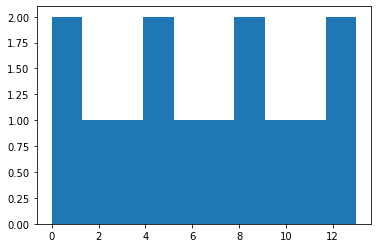

In [7]:
from matplotlib import pyplot as plt
plt.hist(test_labels)

In [9]:
shap_values = {}
explainer = {}
for pid in pids_0_blending:
    print(pid)
    explainer[pid] = {}
    shap_values[pid] = {}
    for i in range(4):
        print(i)
        explainer[pid][i] = shap.TreeExplainer(tree15[pid][i])
        #print(explainer.model)
        shap_values[pid][i] = explainer[pid][i](test_features[pid], test_labels[pid][i])

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



spirits_010
0
1
2
3
spirits_110
0
1
2
3
spirits_000
0
1
2
3
spirits_100
0
1
2
3
spirits_0100
0
1
2
3
spirits_1100
0
1
2
3
spirits_0000
0
1
2
3
spirits_1000
0
1
2
3


In [67]:
print((shap_values.keys()))

dict_keys(['spirits_002', 'spirits_012', 'spirits_102', 'spirits_112', 'spirits_0002', 'spirits_0102', 'spirits_1002', 'spirits_1102', 'spirits_001', 'spirits_011', 'spirits_101', 'spirits_111', 'spirits_0001', 'spirits_0101', 'spirits_1001', 'spirits_1101', 'spirits_000'])


In [61]:
print(shap_values)

['spirits_002', 'spirits_012', 'spirits_102', 'spirits_112', 'spirits_0002', 'spirits_0102', 'spirits_1002', 'spirits_1102', 'spirits_001', 'spirits_011', 'spirits_101', 'spirits_111', 'spirits_0001', 'spirits_0101', 'spirits_1001', 'spirits_1101', 'spirits_000', 'spirits_010', 'spirits_100', 'spirits_110', 'spirits_0000', 'spirits_0100', 'spirits_1000', 'spirits_1100']


In [18]:
#problem_ids = pids_0_blending
explainer = {pid: explainer[pid] for pid in problem_ids}
shap_values = {pid: shap_values[pid] for pid in problem_ids}
for pid in problem_ids:
    #as background data sample 100 random data points from the training features
    background_data = features[pid][np.random.choice(features[pid].shape[0], 100, replace=False)]
    print(background_data.shape)

    for i in range(4):
        print(i)
        explainer[pid][i] = shap.KernelExplainer(polynomial5[pid][i].predict,background_data)
        shap_values[pid][i] = explainer[pid][i].shap_values(test_features[pid], nsamples=100)
        



(100, 11)
0


100%|██████████| 5000/5000 [59:13<00:00,  1.41it/s] 


1


100%|██████████| 5000/5000 [58:05<00:00,  1.43it/s] 


2


100%|██████████| 5000/5000 [59:00<00:00,  1.41it/s] 


3


100%|██████████| 5000/5000 [58:48<00:00,  1.42it/s] 


(100, 11)
0


100%|██████████| 5000/5000 [58:23<00:00,  1.43it/s] 


1


100%|██████████| 5000/5000 [58:32<00:00,  1.42it/s] 


2


100%|██████████| 5000/5000 [57:20<00:00,  1.45it/s] 


3


100%|██████████| 5000/5000 [57:45<00:00,  1.44it/s]  


(100, 11)
0


100%|██████████| 5000/5000 [58:34<00:00,  1.42it/s] 


1


100%|██████████| 5000/5000 [58:58<00:00,  1.41it/s] 


2


100%|██████████| 5000/5000 [59:02<00:00,  1.41it/s] 


3


100%|██████████| 5000/5000 [58:54<00:00,  1.41it/s] 


(100, 11)
0


100%|██████████| 5000/5000 [59:02<00:00,  1.41it/s] 


1


100%|██████████| 5000/5000 [58:30<00:00,  1.42it/s]


2


100%|██████████| 5000/5000 [58:54<00:00,  1.41it/s]


3


100%|██████████| 5000/5000 [58:49<00:00,  1.42it/s] 


(100, 11)
0


100%|██████████| 5000/5000 [59:17<00:00,  1.41it/s] 


1


100%|██████████| 5000/5000 [59:05<00:00,  1.41it/s] 


2


100%|██████████| 5000/5000 [59:10<00:00,  1.41it/s] 


3


100%|██████████| 5000/5000 [58:55<00:00,  1.41it/s] 


(100, 11)
0


100%|██████████| 5000/5000 [58:45<00:00,  1.42it/s] 


1


100%|██████████| 5000/5000 [58:42<00:00,  1.42it/s] 


2


100%|██████████| 5000/5000 [58:52<00:00,  1.42it/s] 


3


100%|██████████| 5000/5000 [58:50<00:00,  1.42it/s]


(100, 11)
0


100%|██████████| 5000/5000 [58:34<00:00,  1.42it/s]


1


100%|██████████| 5000/5000 [58:41<00:00,  1.42it/s] 


2


100%|██████████| 5000/5000 [58:44<00:00,  1.42it/s] 


3


100%|██████████| 5000/5000 [59:11<00:00,  1.41it/s] 


(100, 11)
0


100%|██████████| 5000/5000 [59:12<00:00,  1.41it/s] 


1


100%|██████████| 5000/5000 [58:53<00:00,  1.42it/s] 


2


100%|██████████| 5000/5000 [58:32<00:00,  1.42it/s] 


3


100%|██████████| 5000/5000 [1:00:48<00:00,  1.37it/s]


In [10]:
#save explainer and shap values
import pickle
# for pid in pids_average_blending+pids_minimum_blending:
#     with open(f"C:\\Users\\ga84cib\\Documents\\gitlab\\ameliorating_inventory_drl\\problem_configurations\\{pid}\\shap_values_tree15.pkl", "wb") as f:
#         pickle.dump(shap_values[pid], f)
#     with open(f"C:\\Users\\ga84cib\\Documents\\gitlab\\ameliorating_inventory_drl\\problem_configurations\\{pid}\\explainer_tree15.pkl", "wb") as f:
#         pickle.dump(explainer[pid], f)
for pid in pids_0_blending:
    with open(f"C:\\Users\\ga84cib\\Documents\\gitlab\\ameliorating_inventory_drl\\problem_configurations\\{pids_average_blending[pids_0_blending.index(pid)]}\\training_results\\0_blending_p_nn_xy_lp\\shap_values_tree15.pkl", "wb") as f:
        pickle.dump(shap_values[pid], f)
    with open(f"C:\\Users\\ga84cib\\Documents\\gitlab\\ameliorating_inventory_drl\\problem_configurations\\{pids_average_blending[pids_0_blending.index(pid)]}\\training_results\\0_blending_p_nn_xy_lp\\explainer_tree15.pkl", "wb") as f:
        pickle.dump(explainer[pid], f)



In [58]:
#save explainer and shape values
import pickle
with open(f"C:\\Users\\ga84cib\\Documents\\gitlab\\ameliorating_inventory_drl\\problem_configurations\\{pid}\\training_results\\full_blending_p_nn_xy_lp\\shap_explainer.pkl", "wb") as f:
    pickle.dump(explainer, f)
with open(f"C:\\Users\\ga84cib\\Documents\\gitlab\\ameliorating_inventory_drl\\problem_configurations\\{pid}\\training_results\\full_blending_p_nn_xy_lp\\shap_values.pkl", "wb") as f:
    pickle.dump(shap_values, f)


In [9]:
#load shap values and explainer
import pickle
shap_values_min = pickle.load(open("C:\\Users\\ga84cib\\Documents\\gitlab\\ameliorating_inventory_drl\\problem_configurations\\shap_values_minimum.pkl", "rb"))
explainer_min = pickle.load(open("C:\\Users\\ga84cib\\Documents\\gitlab\\ameliorating_inventory_drl\\problem_configurations\\explainer_minimum.pkl", "rb"))

shap_values_avg = pickle.load(open("C:\\Users\\ga84cib\\Documents\\gitlab\\ameliorating_inventory_drl\\problem_configurations\\shap_values_average.pkl", "rb"))
explainer_avg = pickle.load(open("C:\\Users\\ga84cib\\Documents\\gitlab\\ameliorating_inventory_drl\\problem_configurations\\explainer_average.pkl", "rb"))


Trying to unpickle estimator PolynomialFeatures from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
Trying to unpickle estimator LinearRegression from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
Trying to unpickle estimator Pipeline from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations


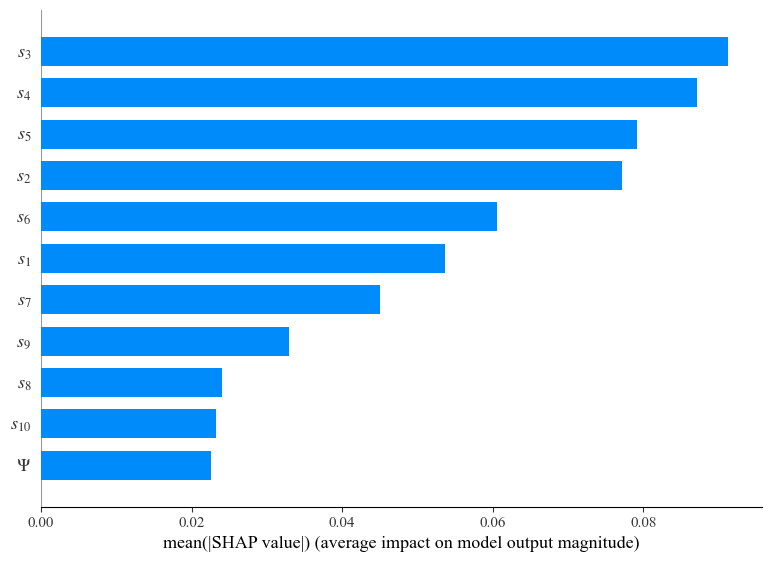

{0: array([[-0.68343161, -0.0602867 ,  0.0235837 , ..., -0.04642254,
        -0.06196091,  0.02876073],
       [ 0.31129416,  0.        ,  0.        , ...,  0.01963481,
        -0.01070681, -0.00858217],
       [ 0.33899362,  0.        ,  0.        , ..., -0.01679899,
         0.00976906,  0.        ],
       ...,
       [ 0.22565126, -0.0662768 ,  0.07624508, ...,  0.09318903,
         0.23170145, -0.05716802],
       [-0.04579578, -0.07697703, -0.04925788, ...,  0.10069735,
         0.13499024,  0.17728171],
       [-0.06154411, -0.0354065 , -0.11333765, ..., -0.04505075,
         0.12362589,  0.18422974]]), 1: array([[-0.02703047,  0.03717237, -0.10600005, ..., -0.01844107,
        -0.0410736 ,  0.01982825],
       [ 0.00992111, -0.07366461,  0.0685747 , ...,  0.05287598,
        -0.03876926, -0.01256765],
       [ 0.01858148,  0.03470699, -0.10996717, ..., -0.00418242,
         0.01642802, -0.01044615],
       ...,
       [-0.0438757 ,  0.10005907,  0.01050551, ...,  0.06887543,
  

In [34]:
pid = "spirits_1002"


#change math font to stix
from matplotlib import pyplot as plt
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["mathtext.fontset"] = "stix"
plt.rcParams.update({'font.size': 16})
#change plot font size


shap.summary_plot(shap_values[pid][1], test_features[pid], feature_names=feature_names, plot_type="bar")

print(shap_values[pid])

{0: array([[ 0.58262944,  0.00846909,  0.02453578, ...,  0.00421859,
         0.00551856, -0.02161589],
       [ 0.70809039, -0.0554611 ,  0.        , ..., -0.00704929,
         0.        ,  0.        ],
       [-0.22403772, -0.07512767, -0.05483721, ...,  0.        ,
         0.        , -0.02523574],
       ...,
       [-0.37540876,  0.12003106, -0.00544048, ...,  0.        ,
        -0.00413643,  0.        ],
       [ 0.33208669,  0.11361397,  0.04778239, ...,  0.0030595 ,
         0.        , -0.01678441],
       [-0.19822323, -0.13079119,  0.03277791, ..., -0.00328213,
        -0.0020592 , -0.00120364]]), 1: array([[ 0.01424935,  0.02746624, -0.06977682, ...,  0.00522859,
         0.00277345, -0.00724791],
       [ 0.        ,  0.02434415,  0.03747082, ...,  0.01526532,
         0.        , -0.01130383],
       [-0.00806773,  0.01976764,  0.08119192, ...,  0.        ,
        -0.0113026 ,  0.        ],
       ...,
       [-0.0130976 , -0.04792455,  0.05709848, ...,  0.        ,
  

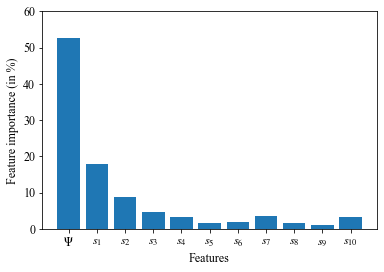

In [66]:
import matplotlib.pyplot as plt 
import pandas as pd

pid = "spirits_001"
# Calculate mean absolute SHAP values for each feature
print(shap_values_min[pid])

mean_abs_shap_values = [np.mean(np.abs(shap_values_min[pid][0][:,i])) for i in range(11)]

print(mean_abs_shap_values)

print(len(shap_values_min[pid][0]))

# Normalize the SHAP values so they sum to 1
normalized_shap_values = mean_abs_shap_values/np.sum(mean_abs_shap_values)

print(normalized_shap_values)

# Plot normalized feature importance
plt.bar(range(len(feature_names)), normalized_shap_values, tick_label=feature_names)
#plt.title('Average blending regime')
plt.xlabel('Features')
# plt.yticks([0.0,0.1,0.2,0.3], ["0", "10", "20", "30"])
plt.yticks([0.0,0.1,0.2,0.3,0.4,0.5,0.6], ["0", "10", "20", "30", "40", "50", "60"])
plt.ylabel('Feature importance (in %)')
plt.savefig("C:/Users/ga84cib/Documents/gitlab/ameliorating_inventory_drl/problem_configurations/spirits_001/feature_importance_p.pdf")
plt.show()

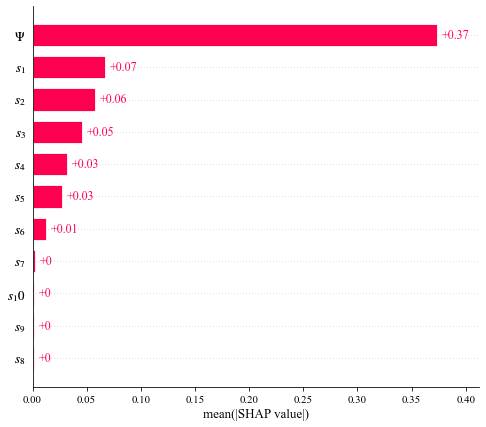

In [23]:

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["mathtext.fontset"] = "stix"
shap_values.feature_names = feature_names
shap.plots.bar(shap_values, max_display=None)

0.6420479105265171
0.3001967668533325
0.6881258314929584
0.12460675835609436
0.5401147072921935
0.3844846189022064
0.5673798507886564
0.7018289566040039
0.4926493558069508
0.7458327412605286
0.606850736492176
0.602302610874176
0.6435137707480817
0.2026706039905548
0.5538961321156061
0.7590712308883667
0.5437493358741616
0.4967661201953888
0.5213105943414
0.6080226898193359
0.5024538329768676
0.42462849617004395
0.6775395297838366
0.49928057193756104
0.6891528078331327
0.3659692406654358
0.32296529388887374
0.5882188081741333
0.5720940899106158
0.36275675892829895
0.479375769123246
0.3746704161167145
0.5039372595721258
0.5310313701629639
0.5269037297450302
0.6659321784973145
0.6751356344814187
0.3046986758708954
0.5939650001193012
0.47685477137565613
0.6130461534059917
0.40743428468704224
0.369
0.533230209350586
0.3574463782051155
0.3554637134075165
0.419798142753048
0.6543140411376953
0.48297129898461344
0.41754093766212463
0.6052532457672901
0.10193958878517151
0.5446896305950794
0.62

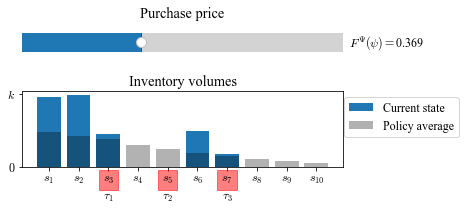

[0.369 0.949 0.982 0.447 0.    0.    0.49  0.18  0.    0.    0.   ]
{0: array([0.29777896, 0.        , 1.        , ..., 0.        , 1.        ,
       0.        ]), 1: array([0.144, 0.142, 0.144, ..., 0.14 , 0.14 , 0.14 ]), 2: array([0.142, 0.142, 0.142, ..., 0.138, 0.142, 0.142]), 3: array([0.1262755 , 0.12720011, 0.12449406, ..., 0.12      , 0.12106363,
       0.12289316]), 4: array([0., 0., 0., ..., 0., 0., 0.]), 5: array([0.        , 0.07392753, 0.        , ..., 0.0728863 , 0.        ,
       0.        ]), 6: array([0.15299748, 0.        , 0.15299748, ..., 0.        , 0.14874755,
       0.14874755]), 7: array([0.19121426, 0.07697577, 0.        , ..., 0.10825598, 0.        ,
       0.07697577]), 8: array([0.        , 0.15709341, 0.15709341, ..., 0.19265434, 0.23745242,
       0.        ]), 9: array([0.00863777, 0.        , 0.07575636, ..., 0.        , 0.        ,
       0.0801497 ]), 10: array([0.        , 0.14652272, 0.        , ..., 0.        , 0.        ,
       0.14156151]), 11:

In [54]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.widgets import Slider

pid = "spirits_012"

average_inventory = np.mean(test_features[pid][:,1:], axis=0)

idxs = np.where((test_labels[pid][0] > 0.3) & (test_labels[pid][0] < 0.7))[0]

ids = []
for i  in idxs:
    print(test_features[pid][i][0])
    print(tree20[pid][0].predict(test_features[pid][i].reshape(1,-1))[0])
    if test_features[pid][i][0] < 0.5 and abs(tree15[pid][0].predict(test_features[pid][i].reshape(1,-1))[0] - test_labels[pid][0][i]) < 0.2:
        ids = np.append(ids, i)

# don't show gridlines inside the plot
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams.update({'font.size': 12})



print(ids)       
idx = int(ids[3])
      
if True:    
    
    
    print(idx)
    print([test_labels[pid][i][idx] for i in range(11)])
    #provide a visual illustration of single state variables composed of purchase price and inventory level to use in a paper to show how a state looks like, the tree or the labels or shap values are irrelevant for this plot, I just want to show how a state looks like
    #state = test_features[pid][idx]
    #replicate state from the paper 
    state = [0.369, 0.949, 0.982, 0.447, 0.0, 0.0, 0.49, 0.18, 0.0, 0.0, 0.0]
    test_features[pid][idx] = state
    test_labels[pid][0][idx] = tree20[pid][0].predict(test_features[pid][idx].reshape(1,-1))[0]
    test_labels[pid][1][idx] = tree20[pid][1].predict(test_features[pid][idx].reshape(1,-1))[0]
    test_labels[pid][2][idx] = tree20[pid][2].predict(test_features[pid][idx].reshape(1,-1))[0]
    test_labels[pid][3][idx] = tree20[pid][3].predict(test_features[pid][idx].reshape(1,-1))[0]
    #adapt plot font size
    plt.rcParams["font.family"] = "Times New Roman"
    plt.rcParams["mathtext.fontset"] = "cm"
    plt.rcParams.update({'font.size': 12})
    plt.rcParams["grid.linewidth"] = 0.0
    #use different subplots for the price and the inventory level with bars of equal width for the price and the 10 inventory levels (so the left plot should be 10 times smaller than the right plot)
    fig = plt.figure(figsize=(7,3.3))
    gs = gridspec.GridSpec(2, 1, height_ratios=[1, 2])
    ax = [plt.subplot(gs[0]), plt.subplot(gs[1])]
    #show the price as a slider with a range from 0 to 1 with min and max values of the price distribution
    ax[0].axis("off")
    ax[0].set_title("Purchase price")
    price_slider = Slider(ax[0], "", 0, 1, valinit=state[0], valfmt="$F^{\Psi}(\psi)=$""%1.3f")


    ax[1].bar([f"$s_{{{i+1}}}$" for i in range(10)], state[1:])
    ax[1].bar([f"$s_{{{i+1}}}$" for i in range(10)], average_inventory, color = "black",  alpha=0.3)
    #make a red box around the ticks for s_3, s_5, and s_7 on the x-axis


    ax[1].set_title("Inventory volumes")
    #ax[1].set_ylabel("Inventory level")
    ax[1].set_yticks([0,1.0], ["$0$", "$k$"])
    #ax[1].set_xlabel("Age class", labelpad=20)

    #add a legend for the average inventory level
    ax[1].legend(["Current state", "Policy average"], loc="upper right", bbox_to_anchor=(1.38,1))  

    # add a red box around the ticks for s_3, s_5, and s_7 and a text below the box indicating \tau_1, \tau_2 and \tau_3
    for i in [2,4,6]:
        ax[1].get_xticklabels()[i].set_bbox(dict(facecolor='red', alpha=0.5, edgecolor='red'))
        ax[1].text(i, -0.45, f"$\\tau_{{{(i+1)//2}}}$", ha="center")


    plt.tight_layout()
    plt.savefig("C:/Users/ga84cib/Documents/gitlab/ameliorating_inventory_drl/problem_configurations/state_example_diss.pdf", dpi=300)
plt.show()

print(test_features[pid][idx])
print(test_labels[pid])


[ 114  137  167  170  181  207  254  263  265  267  341  422  472  488
  510  571  574  616  630  636  639  647  680  695  734  763  820  850
  897  918  929  952  968 1049 1080 1130 1138 1168 1180 1188 1223 1246
 1278 1307 1309 1317 1332 1334 1349 1367 1416 1427 1428 1460 1477 1505
 1542 1582 1586 1599 1605 1608 1614 1644 1651 1658 1678 1710 1716 1720
 1730 1745 1753 1807 1816 1825 1853 1878 1922 1923 1982 1983 2018 2042
 2058 2067 2094 2105 2108 2174 2186 2237 2270 2277 2331 2338 2340 2350
 2357 2365 2388 2398 2415 2423 2441 2476 2523 2589 2600 2642 2646 2660
 2674 2692 2698 2706 2778 2828 2833 2845 2864 2875 2894 2908 2929 2967
 3014 3078 3094 3145 3150 3154 3163 3205 3253 3289 3316 3365 3385 3388
 3402 3412 3442 3453 3481 3522 3545 3556 3560 3567 3572 3583 3595 3654
 3667 3705 3716 3783 3798 3810 3815 3844 3898 3926 3937 3947 3982 3986
 4074 4089 4116 4152 4175 4259 4298 4301 4317 4345 4360 4391 4398 4419
 4422 4445 4475 4503 4533 4576 4582 4607 4684 4702 4725 4730 4749 4834
 4857 

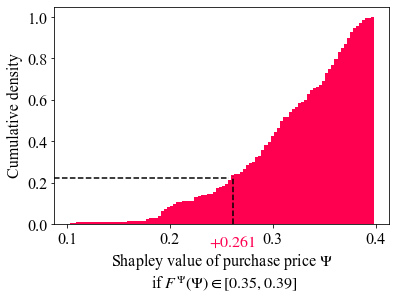

CORRELATION:  [[ 1.         -0.91346838]
 [-0.91346838  1.        ]]


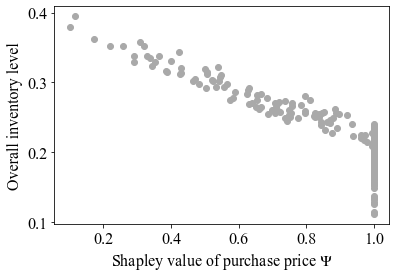

In [51]:
from shap.plots import colors

pid = "spirits_012"


#get all states where price is between 0.364 and 0.374
idxs = np.where((test_features[pid][:,0] > 0.35) & (test_features[pid][:,0] < 0.39))[0]

print(idxs)

#get shapley values of price for all states where price is between 0.364 and 0.374
shaps_price = shap_values[pid][0][idxs].values[:,0]
print(shaps_price)
purchase_qty = test_labels[pid][0][idxs]

#get overall inventory level for all states where price is between 0.364 and 0.374
inventory = np.mean(test_features[pid][idxs][:,1:], axis=1)
print(inventory)
young_inventory = np.mean(test_features[pid][idxs][:,1:3], axis=1)
print(young_inventory)

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["mathtext.fontset"] = "stix"
plt.rcParams.update({'font.size': 16})

#print histogram of shapley values of price
plt.hist(shaps_price, cumulative=True, bins=100, density=True, color=colors.red_rgb)
#insert a vertical red line at 0.261 that reaches until the corresponding y value of the histogram
plt.axvline(0.261, color="black", ymax=0.22, linestyle="--")
#insert a horizontal red line at 0.22 that reaches until the corresponding x value of the histogram
plt.axhline(0.22, color="black", xmax=0.261*2, linestyle="--")

plt.xlabel("Shapley value of purchase price $\psi$ \n if $F^{\Psi}(\psi) \in [0.35,0.39]$")
plt.ylabel("Cumulative density")

#add text at x=0.261
plt.text(0.261, -0.05, "$+0.261$", ha="center", va="top", color=colors.red_rgb)

plt.savefig("C:/Users/ga84cib/Documents/gitlab/ameliorating_inventory_drl/problem_configurations/shap_price.pdf", dpi=300)

plt.show()

# #print scatter plot of shapley values of price and overall inventory level
# plt.scatter(purchase_qty, inventory, color="darkgrey")
# print("CORRELATION: ", np.corrcoef(purchase_qty, inventory))
# #plt.scatter(shaps_price, young_inventory, color="black")
# plt.xlabel("Shapley value of purchase price $\Psi$")
# plt.ylabel("Overall inventory level")
# plt.savefig("C:/Users/ga84cib/Documents/gitlab/ameliorating_inventory_drl/problem_configurations/shap_price_inventory.pdf", dpi=300)

# plt.show()





In [32]:
explainer = {}
shap_values = {}
tree = {}   
for pid in pids_average_blending+pids_minimum_blending:
    tree[pid] = pickle.load(open(f"C:\\Users\\ga84cib\\Documents\\gitlab\\ameliorating_inventory_drl\\problem_configurations\\{pid}\\training_results\\full_blending_p_nn_xy_lp_50w\\tree15.pkl", "rb"))
    explainer[pid] = pickle.load(open(f"C:\\Users\\ga84cib\\Documents\\gitlab\\ameliorating_inventory_drl\\problem_configurations\\{pid}\\explainer_tree15.pkl", "rb"))
    shap_values[pid] = pickle.load(open(f"C:\\Users\\ga84cib\\Documents\\gitlab\\ameliorating_inventory_drl\\problem_configurations\\{pid}\\shap_values_tree15.pkl", "rb"))
for pid in pids_0_blending:
    tree[pid] = pickle.load(open(f"C:\\Users\\ga84cib\\Documents\\gitlab\\ameliorating_inventory_drl\\problem_configurations\\{pids_average_blending[pids_0_blending.index(pid)]}\\training_results\\0_blending_p_nn_xy_lp\\tree15.pkl", "rb"))
    explainer[pid] = pickle.load(open(f"C:\\Users\\ga84cib\\Documents\\gitlab\\ameliorating_inventory_drl\\problem_configurations\\{pids_average_blending[pids_0_blending.index(pid)]}\\training_results\\0_blending_p_nn_xy_lp\\explainer_tree15.pkl", "rb"))
    shap_values[pid] = pickle.load(open(f"C:\\Users\\ga84cib\\Documents\\gitlab\\ameliorating_inventory_drl\\problem_configurations\\{pids_average_blending[pids_0_blending.index(pid)]}\\training_results\\0_blending_p_nn_xy_lp\\shap_values_tree15.pkl", "rb"))

In [60]:
# import importlib
# importlib.reload(shap.plots._waterfall)
# from shap.plots._waterfall import waterfall
# import matplotlib.pyplot as plt
from shap import TreeExplainer

pid = "spirits_012"
expl = explainer[pid][0]
print(tree15[pid][0].predict(test_features[pid][idx].reshape(1,-1)))
print(test_labels[pid][0][idx])
explr = TreeExplainer(tree15[pid][0])
shap_value = explr.shap_values(test_features[pid][idx])


print(shap_value)

# print(features[pid][idx])
# print(shap_values_avg[pid][0][idx])
# shap_value = explainer_avg[pid][0].shap_values(features[pid][idx])
#turn shap_value into an Explanation object

shap_value = shap.Explanation(values=shap_value, base_values=explr.expected_value, data=test_features[pid][idx], feature_names=feature_names)
#provides a plot for the shap value for each feature for a single observation with feature names and different colors for positive and negative values
#the bars should originate at the base value and accumulate to the final output value

#summary plot of Shap values for all observations
#waterfall(shap_values[1993], feature_names=feature_names)


#shap.initjs()
#create waterfall plot and save it
#shap.plots.waterfall(shap_value, feature_names=feature_names, max_display=12)
#plt1.savefig("C:/Users/ga84cib/Documents/gitlab/ameliorating_inventory_drl/problem_configurations/spirits_102/waterfall.pdf")



[0.51858578]
0.533230209350586
[ 2.60537607e-01 -1.40789453e-01 -1.29244544e-01 -4.69876303e-02
  5.05250619e-02  3.69214054e-02 -1.15446458e-02  4.88308083e-03
  6.63387609e-05 -1.62546773e-03 -5.61620188e-04]


Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)


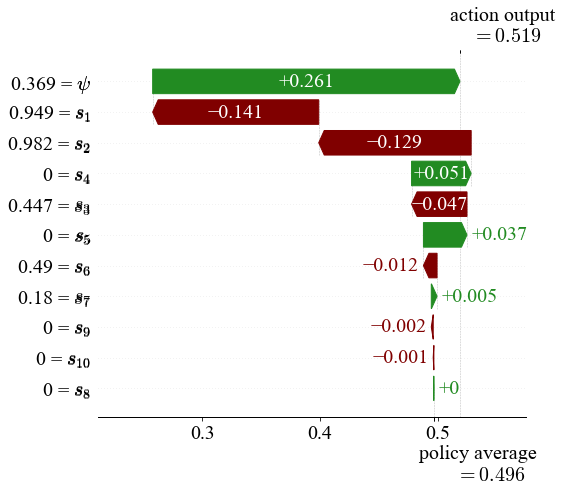

In [61]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from shap._explanation import Explanation
from shap.utils import format_value
from shap.plots import colors
from shap.plots._labels import labels


def waterfall(shap_values, feature_names=None, max_display=10, show=True):
    """Plots an explanation of a single prediction as a waterfall plot.

    The SHAP value of a feature represents the impact of the evidence provided by that feature on the model's
    output. The waterfall plot is designed to visually display how the SHAP values (evidence) of each feature
    move the model output from our prior expectation under the background data distribution, to the final model
    prediction given the evidence of all the features.

    Features are sorted by the magnitude of their SHAP values with the smallest
    magnitude features grouped together at the bottom of the plot when the number of
    features in the models exceeds the ``max_display`` parameter.

    Parameters
    ----------
    shap_values : Explanation
        A one-dimensional :class:`.Explanation` object that contains the feature values and SHAP values to plot.

    max_display : str
        The maximum number of features to plot (default is 10).

    show : bool
        Whether ``matplotlib.pyplot.show()`` is called before returning.
        Setting this to ``False`` allows the plot to be customized further after it
        has been created, returning the current axis via plt.gca().

    Examples
    --------

    See `waterfall plot examples <https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/plots/waterfall.html>`_.

    """

    # Turn off interactive plot
    if show is False:
        plt.ioff()

    # make sure the input is an Explanation object
    if not isinstance(shap_values, Explanation):
        emsg = (
            "The waterfall plot requires an `Explanation` object as the "
            "`shap_values` argument."
        )
        raise TypeError(emsg)

    # make sure we only have a single explanation to plot
    sv_shape = shap_values.shape
    if len(sv_shape) != 1:
        emsg = (
            "The waterfall plot can currently only plot a single explanation, but a "
            f"matrix of explanations (shape {sv_shape}) was passed! Perhaps try "
            "`shap.plots.waterfall(shap_values[0])` or for multi-output models, "
            "try `shap.plots.waterfall(shap_values[0, 0])`."
        )
        raise ValueError(emsg)

    base_values = float(shap_values.base_values)
    features = shap_values.display_data if shap_values.display_data is not None else shap_values.data
    feature_names = shap_values.feature_names
    lower_bounds = getattr(shap_values, "lower_bounds", None)
    upper_bounds = getattr(shap_values, "upper_bounds", None)
    values = shap_values.values

    # unwrap pandas series
    if isinstance(features, pd.Series):
        if feature_names is None:
            feature_names = list(features.index)
        features = features.values

    # fallback feature names
    if feature_names is None:
        feature_names = np.array([labels['FEATURE'] % str(i) for i in range(len(values))])

    # init variables we use for tracking the plot locations
    num_features = min(max_display, len(values))
    row_height = 0.5
    rng = range(num_features - 1, -1, -1)
    order = np.argsort(-np.abs(values))
    pos_lefts = []
    pos_inds = []
    pos_widths = []
    pos_low = []
    pos_high = []
    neg_lefts = []
    neg_inds = []
    neg_widths = []
    neg_low = []
    neg_high = []
    loc = base_values + values.sum()
    yticklabels = ["" for _ in range(num_features + 1)]

    # size the plot based on how many features we are plotting
    plt.gcf().set_size_inches(8, num_features * row_height + 1.5)

    # see how many individual (vs. grouped at the end) features we are plotting
    if num_features == len(values):
        num_individual = num_features
    else:
        num_individual = num_features - 1

    # compute the locations of the individual features and plot the dashed connecting lines
    for i in range(num_individual):
        sval = values[order[i]]
        loc -= sval
        if sval >= 0:
            pos_inds.append(rng[i])
            pos_widths.append(sval)
            if lower_bounds is not None:
                pos_low.append(lower_bounds[order[i]])
                pos_high.append(upper_bounds[order[i]])
            pos_lefts.append(loc)
        else:
            neg_inds.append(rng[i])
            neg_widths.append(sval)
            if lower_bounds is not None:
                neg_low.append(lower_bounds[order[i]])
                neg_high.append(upper_bounds[order[i]])
            neg_lefts.append(loc)
        if num_individual != num_features or i + 4 < num_individual:
            plt.plot([loc, loc], [rng[i] - 1 - 0.4, rng[i] + 0.4],
                     color="#bbbbbb", linestyle="--", linewidth=0.5, zorder=-1)
        if features is None:
            yticklabels[rng[i]] = feature_names[order[i]]
        else:
            if np.issubdtype(type(features[order[i]]), np.number):
                yticklabels[rng[i]] = format_value(float(features[order[i]]), "%0.03f") + " = " + feature_names[order[i]]
            else:
                yticklabels[rng[i]] = str(features[order[i]]) + " = " + str(feature_names[order[i]])

    # add a last grouped feature to represent the impact of all the features we didn't show
    if num_features < len(values):
        yticklabels[0] = "%d other features" % (len(values) - num_features + 1)
        remaining_impact = base_values - loc
        if remaining_impact < 0:
            pos_inds.append(0)
            pos_widths.append(-remaining_impact)
            pos_lefts.append(loc + remaining_impact)
        else:
            neg_inds.append(0)
            neg_widths.append(-remaining_impact)
            neg_lefts.append(loc + remaining_impact)

    points = pos_lefts + list(np.array(pos_lefts) + np.array(pos_widths)) + neg_lefts + \
        list(np.array(neg_lefts) + np.array(neg_widths))
    dataw = np.max(points) - np.min(points)

    # draw invisible bars just for sizing the axes
    label_padding = np.array([0.1*dataw if w < 1 else 0 for w in pos_widths])
    plt.barh(pos_inds, np.array(pos_widths) + label_padding + 0.02*dataw,
             left=np.array(pos_lefts) - 0.01*dataw, color="forestgreen", alpha=0)
    label_padding = np.array([-0.1*dataw if -w < 1 else 0 for w in neg_widths])
    plt.barh(neg_inds, np.array(neg_widths) + label_padding - 0.02*dataw,
             left=np.array(neg_lefts) + 0.01*dataw, color="maroon", alpha=0)

    # define variable we need for plotting the arrows
    head_length = 0.08
    bar_width = 0.8
    xlen = plt.xlim()[1] - plt.xlim()[0]
    fig = plt.gcf()
    ax = plt.gca()
    bbox = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    width = bbox.width
    bbox_to_xscale = xlen/width
    hl_scaled = bbox_to_xscale * head_length
    renderer = fig.canvas.get_renderer()

    # draw the positive arrows
    for i in range(len(pos_inds)):
        dist = pos_widths[i]
        arrow_obj = plt.arrow(
            pos_lefts[i], pos_inds[i], max(dist-hl_scaled, 0.000001), 0,
            head_length=min(dist, hl_scaled),
            color="forestgreen", width=bar_width,
            head_width=bar_width,
        )

        if pos_low is not None and i < len(pos_low):
            plt.errorbar(
                pos_lefts[i] + pos_widths[i], pos_inds[i],
                xerr=np.array([[pos_widths[i] - pos_low[i]], [pos_high[i] - pos_widths[i]]]),
                ecolor=colors.light_red_rgb,
            )

        txt_obj = plt.text(
            pos_lefts[i] + 0.5*dist, pos_inds[i], format_value(pos_widths[i], '%+0.03f'),
            horizontalalignment='center', verticalalignment='center', color="white",
            fontsize=20,
        )
        text_bbox = txt_obj.get_window_extent(renderer=renderer)
        arrow_bbox = arrow_obj.get_window_extent(renderer=renderer)

        # if the text overflows the arrow then draw it after the arrow
        if text_bbox.width > arrow_bbox.width:
            txt_obj.remove()

            txt_obj = plt.text(
                pos_lefts[i] + (5/72)*bbox_to_xscale + dist, pos_inds[i], format_value(pos_widths[i], '%+0.03f'),
                horizontalalignment='left', verticalalignment='center', color="forestgreen",
                fontsize=20,
            )

    # draw the negative arrows
    for i in range(len(neg_inds)):
        dist = neg_widths[i]

        arrow_obj = plt.arrow(
            neg_lefts[i], neg_inds[i], -max(-dist-hl_scaled, 0.000001), 0,
            head_length=min(-dist, hl_scaled),
            color="maroon", width=bar_width,
            head_width=bar_width,
        )

        if neg_low is not None and i < len(neg_low):
            plt.errorbar(
                neg_lefts[i] + neg_widths[i], neg_inds[i],
                xerr=np.array([[neg_widths[i] - neg_low[i]], [neg_high[i] - neg_widths[i]]]),
                ecolor=colors.light_blue_rgb,
            )

        txt_obj = plt.text(
            neg_lefts[i] + 0.5*dist, neg_inds[i], format_value(neg_widths[i], '%+0.03f'),
            horizontalalignment='center', verticalalignment='center', color="white",
            fontsize=20,
        )
        text_bbox = txt_obj.get_window_extent(renderer=renderer)
        arrow_bbox = arrow_obj.get_window_extent(renderer=renderer)

        # if the text overflows the arrow then draw it after the arrow
        if text_bbox.width > arrow_bbox.width:
            txt_obj.remove()

            txt_obj = plt.text(
                neg_lefts[i] - (5/72)*bbox_to_xscale + dist, neg_inds[i], format_value(neg_widths[i], '%+0.03f'),
                horizontalalignment='right', verticalalignment='center', color="maroon",
                fontsize=20,
            )

    # draw the y-ticks twice, once in gray and then again with just the feature names in black
    # The 1e-8 is so matplotlib 3.3 doesn't try and collapse the ticks
    ytick_pos = list(range(num_features)) + list(np.arange(num_features)+1e-8)
    plt.yticks(ytick_pos, yticklabels[:-1] + [label.split('=')[-1] for label in yticklabels[:-1]], fontsize=13)

    # put horizontal lines for each feature row
    for i in range(num_features):
        plt.axhline(i, color="#cccccc", lw=0.5, dashes=(1, 5), zorder=-1)

    # mark the prior expected value and the model prediction
    plt.axvline(base_values, 0, 1/num_features, color="#bbbbbb", linestyle="--", linewidth=0.5, zorder=-1)
    fx = base_values + values.sum()
    plt.axvline(fx, 0, 1, color="#bbbbbb", linestyle="--", linewidth=0.5, zorder=-1)

    # clean up the main axis
    plt.gca().xaxis.set_ticks_position('bottom')
    plt.gca().yaxis.set_ticks_position('none')
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    ax.tick_params(labelsize=20)
    #plt.xlabel("\nModel output", fontsize=20)

    # draw the E[f(X)] tick mark
    xmin, xmax = ax.get_xlim()
    ax2 = ax.twiny()
    ax2.set_xlim(xmin, xmax)
    ax2.set_xticks([base_values, base_values+1e-8])  # The 1e-8 is so matplotlib 3.3 doesn't try and collapse the ticks
    ax2.set_xticklabels(["\n policy average", "\n\n$ = "+format_value(base_values, "%0.03f")+"$"], fontsize=20, ha="left")
    ax2.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.spines['left'].set_visible(False)

    # draw the f(x) tick mark
    ax3 = ax2.twiny()
    ax3.set_xlim(xmin, xmax)
    # The 1e-8 is so matplotlib 3.3 doesn't try and collapse the ticks
    ax3.set_xticks([base_values + values.sum(), base_values + values.sum() + 1e-8])
    ax3.set_xticklabels(["action output \n", "\n$ = "+format_value(fx, "%0.03f")+"$"], fontsize=20, ha="left")
    tick_labels = ax3.xaxis.get_majorticklabels()
    tick_labels[0].set_transform(tick_labels[0].get_transform(
    ) + matplotlib.transforms.ScaledTranslation(-10/72., 0, fig.dpi_scale_trans))
    tick_labels[1].set_transform(tick_labels[1].get_transform(
    ) + matplotlib.transforms.ScaledTranslation(12/72., 0, fig.dpi_scale_trans))
    #tick_labels[1].set_color("#999999")
    ax3.spines['right'].set_visible(False)
    ax3.spines['top'].set_visible(False)
    ax3.spines['left'].set_visible(False)

    # adjust the position of the E[f(X)] = x.xx label
    tick_labels = ax2.xaxis.get_majorticklabels()
    tick_labels[0].set_transform(tick_labels[0].get_transform(
    ) + matplotlib.transforms.ScaledTranslation(-20/72., 0, fig.dpi_scale_trans))
    tick_labels[1].set_transform(tick_labels[1].get_transform(
    ) + matplotlib.transforms.ScaledTranslation(22/72., -1/72., fig.dpi_scale_trans))

    #tick_labels[1].set_color("#999999")

    # color the y tick labels that have the feature values as gray
    # (these fall behind the black ones with just the feature name)
    tick_labels = ax.yaxis.get_majorticklabels()
    # for i in range(num_features):
    #     tick_labels[i].set_color("#999999")

    #increase plot space to fit figure in it
    plt.tight_layout()

    plt.savefig("C:/Users/ga84cib/Documents/gitlab/ameliorating_inventory_drl/problem_configurations/waterfall_p_diss.pdf")

    if show:
        plt.show()
    else:
        return plt.gca()

waterfall(shap_value, feature_names=feature_names, max_display=12)

In [74]:
""" Summary plots of SHAP values across a whole dataset.
"""

import warnings

import matplotlib.pyplot as pl
import numpy as np
import pandas as pd
import scipy.cluster
import scipy.sparse
import scipy.spatial
from scipy.stats import gaussian_kde

from shap._explanation import Explanation
from shap.utils import safe_isinstance
from shap.utils._exceptions import DimensionError
from shap.plots import colors
from shap.plots._labels import labels
from shap.plots._utils import (
    convert_color,
    convert_ordering,
    get_sort_order,
    merge_nodes,
    sort_inds,
)


def summary_legacy(shap_values, features=None, feature_names=None, max_display=None, plot_type=None,
                 color=None, axis_color="#333333", title=None, alpha=1, show=True, sort=True,
                 color_bar=True, plot_size="auto", layered_violin_max_num_bins=20, class_names=None,
                 class_inds=None,
                 color_bar_label=labels["FEATURE_VALUE"],
                 cmap=colors.red_blue,
                 show_values_in_legend=False,
                 show_feature_names=True,
                 # depreciated
                 auto_size_plot=None,
                 use_log_scale=False):
    """Create a SHAP beeswarm plot, colored by feature values when they are provided.

    Parameters
    ----------
    shap_values : numpy.array
        For single output explanations this is a matrix of SHAP values (# samples x # features).
        For multi-output explanations this is a list of such matrices of SHAP values.

    features : numpy.array or pandas.DataFrame or list
        Matrix of feature values (# samples x # features) or a feature_names list as shorthand

    feature_names : list
        Names of the features (length # features)

    max_display : int
        How many top features to include in the plot (default is 20, or 7 for interaction plots)

    plot_type : "dot" (default for single output), "bar" (default for multi-output), "violin",
        or "compact_dot".
        What type of summary plot to produce. Note that "compact_dot" is only used for
        SHAP interaction values.

    plot_size : "auto" (default), float, (float, float), or None
        What size to make the plot. By default the size is auto-scaled based on the number of
        features that are being displayed. Passing a single float will cause each row to be that
        many inches high. Passing a pair of floats will scale the plot by that
        number of inches. If None is passed then the size of the current figure will be left
        unchanged.

    show_values_in_legend: bool
        Flag to print the mean of the SHAP values in the multi-output bar plot. Set to False
        by default.
    """

    # support passing an explanation object
    if str(type(shap_values)).endswith("Explanation'>"):
        shap_exp = shap_values
        shap_values = shap_exp.values
        if features is None:
            features = shap_exp.data
        if feature_names is None:
            feature_names = shap_exp.feature_names
        # if out_names is None: # TODO: waiting for slicer support of this
        #     out_names = shap_exp.output_names

    # deprecation warnings
    if auto_size_plot is not None:
        warnings.warn("auto_size_plot=False is deprecated and is now ignored! Use plot_size=None instead.")

    multi_class = False
    if isinstance(shap_values, list):
        multi_class = True
        if plot_type is None:
            plot_type = "bar" # default for multi-output explanations
        assert plot_type == "bar", "Only plot_type = 'bar' is supported for multi-output explanations!"
    else:
        if plot_type is None:
            plot_type = "dot" # default for single output explanations
        assert len(shap_values.shape) != 1, "Summary plots need a matrix of shap_values, not a vector."

    # default color:
    if color is None:
        if plot_type == 'layered_violin':
            color = "coolwarm"
        elif multi_class:
            def color(i):
                return colors.red_blue_circle(i / len(shap_values))
        else:
            color = colors.blue_rgb

    idx2cat = None
    # convert from a DataFrame or other types
    if isinstance(features, pd.DataFrame):
        if feature_names is None:
            feature_names = features.columns
        # feature index to category flag
        idx2cat = features.dtypes.astype(str).isin(["object", "category"]).tolist()
        features = features.values
    elif isinstance(features, list):
        if feature_names is None:
            feature_names = features
        features = None
    elif (features is not None) and len(features.shape) == 1 and feature_names is None:
        feature_names = features
        features = None

    num_features = (shap_values[0].shape[1] if multi_class else shap_values.shape[1])

    if features is not None:
        shape_msg = "The shape of the shap_values matrix does not match the shape of the " \
                    "provided data matrix."
        if num_features - 1 == features.shape[1]:
            assert False, shape_msg + " Perhaps the extra column in the shap_values matrix is the " \
                          "constant offset? Of so just pass shap_values[:,:-1]."
        else:
            assert num_features == features.shape[1], shape_msg

    if feature_names is None:
        feature_names = np.array([labels['FEATURE'] % str(i) for i in range(num_features)])

    if use_log_scale:
        pl.xscale('symlog')

    # plotting SHAP interaction values
    if not multi_class and len(shap_values.shape) == 3:

        if plot_type == "compact_dot":
            new_shap_values = shap_values.reshape(shap_values.shape[0], -1)
            new_features = np.tile(features, (1, 1, features.shape[1])).reshape(features.shape[0], -1)

            new_feature_names = []
            for c1 in feature_names:
                for c2 in feature_names:
                    if c1 == c2:
                        new_feature_names.append(c1)
                    else:
                        new_feature_names.append(c1 + "* - " + c2)

            return summary_legacy(
                new_shap_values, new_features, new_feature_names,
                max_display=max_display, plot_type="dot", color=color, axis_color=axis_color,
                title=title, alpha=alpha, show=show, sort=sort,
                color_bar=color_bar, plot_size=plot_size, class_names=class_names,
                color_bar_label="*" + color_bar_label
            )

        if max_display is None:
            max_display = 7
        else:
            max_display = min(len(feature_names), max_display)

        sort_inds = np.argsort(-np.abs(shap_values.sum(1)).sum(0))

        # get plotting limits
        delta = 1.0 / (shap_values.shape[1] ** 2)
        slow = np.nanpercentile(shap_values, delta)
        shigh = np.nanpercentile(shap_values, 100 - delta)
        v = max(abs(slow), abs(shigh))
        slow = -v
        shigh = v

        pl.figure(figsize=(1.5 * max_display + 1, 0.8 * max_display + 1))
        pl.subplot(1, max_display, 1)
        proj_shap_values = shap_values[:, sort_inds[0], sort_inds]
        proj_shap_values[:, 1:] *= 2  # because off diag effects are split in half
        summary_legacy(
            proj_shap_values, features[:, sort_inds] if features is not None else None,
            feature_names=feature_names[sort_inds],
            sort=False, show=False, color_bar=False,
            plot_size=None,
            max_display=max_display
        )
        pl.xlim((slow,shigh))
        pl.xlabel("")
        title_length_limit = 11
        pl.title(shorten_text(feature_names[sort_inds[0]], title_length_limit))
        for i in range(1, min(len(sort_inds), max_display)):
            ind = sort_inds[i]
            pl.subplot(1, max_display, i + 1)
            proj_shap_values = shap_values[:, ind, sort_inds]
            proj_shap_values *= 2
            proj_shap_values[:, i] /= 2  # because only off diag effects are split in half
            summary_legacy(
                proj_shap_values, features[:, sort_inds] if features is not None else None,
                sort=False,
                feature_names=["" for i in range(len(feature_names))],
                show=False,
                color_bar=False,
                plot_size=None,
                max_display=max_display
            )
            pl.xlim((slow,shigh))
            pl.xlabel("")
            if i == min(len(sort_inds), max_display) // 2:
                pl.xlabel(labels['INTERACTION_VALUE'])
            pl.title(shorten_text(feature_names[ind], title_length_limit))
        pl.tight_layout(pad=0, w_pad=0, h_pad=0.0)
        pl.subplots_adjust(hspace=0, wspace=0.1)
        if show:
            pl.show()
        return

    if max_display is None:
        max_display = 20

    if sort:
        # order features by the sum of their effect magnitudes
        if multi_class:
            feature_order = np.argsort(np.sum(np.mean(np.abs(shap_values), axis=1), axis=0))
        else:
            feature_order = np.argsort(np.sum(np.abs(shap_values), axis=0))
        feature_order = feature_order[-min(max_display, len(feature_order)):]
    else:
        feature_order = np.flip(np.arange(min(max_display, num_features)), 0)

    row_height = 0.4
    if plot_size == "auto":
        pl.gcf().set_size_inches(8, len(feature_order) * row_height + 1.5)
    elif type(plot_size) in (list, tuple):
        pl.gcf().set_size_inches(plot_size[0], plot_size[1])
    elif plot_size is not None:
        pl.gcf().set_size_inches(8, len(feature_order) * plot_size + 1.5)
    pl.axvline(x=0, color="#999999", zorder=-1)

    if plot_type == "dot":
        for pos, i in enumerate(feature_order):
            pl.axhline(y=pos, color="#cccccc", lw=0.5, dashes=(1, 5), zorder=-1)
            shaps = shap_values[:, i]
            values = None if features is None else features[:, i]
            inds = np.arange(len(shaps))
            np.random.shuffle(inds)
            if values is not None:
                values = values[inds]
            shaps = shaps[inds]
            colored_feature = True
            try:
                if idx2cat is not None and idx2cat[i]: # check categorical feature
                    colored_feature = False
                else:
                    values = np.array(values, dtype=np.float64)  # make sure this can be numeric
            except Exception:
                colored_feature = False
            N = len(shaps)
            # hspacing = (np.max(shaps) - np.min(shaps)) / 200
            # curr_bin = []
            nbins = 100
            quant = np.round(nbins * (shaps - np.min(shaps)) / (np.max(shaps) - np.min(shaps) + 1e-8))
            inds = np.argsort(quant + np.random.randn(N) * 1e-6)
            layer = 0
            last_bin = -1
            ys = np.zeros(N)
            for ind in inds:
                if quant[ind] != last_bin:
                    layer = 0
                ys[ind] = np.ceil(layer / 2) * ((layer % 2) * 2 - 1)
                layer += 1
                last_bin = quant[ind]
            ys *= 0.9 * (row_height / np.max(ys + 1))

            if features is not None and colored_feature:
                # trim the color range, but prevent the color range from collapsing
                vmin = np.nanpercentile(values, 5)
                vmax = np.nanpercentile(values, 95)
                if vmin == vmax:
                    vmin = np.nanpercentile(values, 1)
                    vmax = np.nanpercentile(values, 99)
                    if vmin == vmax:
                        vmin = np.min(values)
                        vmax = np.max(values)
                if vmin > vmax: # fixes rare numerical precision issues
                    vmin = vmax

                assert features.shape[0] == len(shaps), "Feature and SHAP matrices must have the same number of rows!"

                # plot the nan values in the interaction feature as grey
                nan_mask = np.isnan(values)
                pl.scatter(shaps[nan_mask], pos + ys[nan_mask], color="#777777",
                           s=16, alpha=alpha, linewidth=0,
                           zorder=3, rasterized=len(shaps) > 500)

                # plot the non-nan values colored by the trimmed feature value
                cvals = values[np.invert(nan_mask)].astype(np.float64)
                cvals_imp = cvals.copy()
                cvals_imp[np.isnan(cvals)] = (vmin + vmax) / 2.0
                cvals[cvals_imp > vmax] = vmax
                cvals[cvals_imp < vmin] = vmin
                
                pl.scatter(shaps[np.invert(nan_mask)], pos + ys[np.invert(nan_mask)],
                           cmap=cmap, vmin=vmin, vmax=vmax, s=3,
                           c=cvals, alpha=alpha, linewidth=0,
                           zorder=1, rasterized=len(shaps) > 500,)
            else:

                pl.scatter(shaps, pos + ys, s=16, alpha=alpha, linewidth=0, zorder=3,
                           color=color if colored_feature else "#777777", rasterized=len(shaps) > 500)

    elif plot_type == "violin":
        for pos, i in enumerate(feature_order):
            pl.axhline(y=pos, color="#cccccc", lw=0.5, dashes=(1, 5), zorder=-1)

        if features is not None:
            global_low = np.nanpercentile(shap_values[:, :len(feature_names)].flatten(), 1)
            global_high = np.nanpercentile(shap_values[:, :len(feature_names)].flatten(), 99)
            for pos, i in enumerate(feature_order):
                shaps = shap_values[:, i]
                shap_min, shap_max = np.min(shaps), np.max(shaps)
                rng = shap_max - shap_min
                xs = np.linspace(np.min(shaps) - rng * 0.2, np.max(shaps) + rng * 0.2, 100)
                if np.std(shaps) < (global_high - global_low) / 100:
                    ds = gaussian_kde(shaps + np.random.randn(len(shaps)) * (global_high - global_low) / 100)(xs)
                else:
                    ds = gaussian_kde(shaps)(xs)
                ds /= np.max(ds) * 3

                values = features[:, i]
                # window_size = max(10, len(values) // 20)
                smooth_values = np.zeros(len(xs) - 1)
                sort_inds = np.argsort(shaps)
                trailing_pos = 0
                leading_pos = 0
                running_sum = 0
                back_fill = 0
                for j in range(len(xs) - 1):

                    while leading_pos < len(shaps) and xs[j] >= shaps[sort_inds[leading_pos]]:
                        running_sum += values[sort_inds[leading_pos]]
                        leading_pos += 1
                        if leading_pos - trailing_pos > 20:
                            running_sum -= values[sort_inds[trailing_pos]]
                            trailing_pos += 1
                    if leading_pos - trailing_pos > 0:
                        smooth_values[j] = running_sum / (leading_pos - trailing_pos)
                        for k in range(back_fill):
                            smooth_values[j - k - 1] = smooth_values[j]
                    else:
                        back_fill += 1

                vmin = np.nanpercentile(values, 5)
                vmax = np.nanpercentile(values, 95)
                if vmin == vmax:
                    vmin = np.nanpercentile(values, 1)
                    vmax = np.nanpercentile(values, 99)
                    if vmin == vmax:
                        vmin = np.min(values)
                        vmax = np.max(values)

                # plot the nan values in the interaction feature as grey
                nan_mask = np.isnan(values)
                pl.scatter(shaps[nan_mask], np.ones(shap_values[nan_mask].shape[0]) * pos,
                           color="#777777", s=9,
                           alpha=alpha, linewidth=0, zorder=1)
                # plot the non-nan values colored by the trimmed feature value
                cvals = values[np.invert(nan_mask)].astype(np.float64)
                cvals_imp = cvals.copy()
                cvals_imp[np.isnan(cvals)] = (vmin + vmax) / 2.0
                cvals[cvals_imp > vmax] = vmax
                cvals[cvals_imp < vmin] = vmin
                pl.scatter(shaps[np.invert(nan_mask)], np.ones(shap_values[np.invert(nan_mask)].shape[0]) * pos,
                           cmap=cmap, vmin=vmin, vmax=vmax, s=9,
                           c=cvals, alpha=alpha, linewidth=0, zorder=1)
                # smooth_values -= nxp.nanpercentile(smooth_values, 5)
                # smooth_values /= np.nanpercentile(smooth_values, 95)
                smooth_values -= vmin
                if vmax - vmin > 0:
                    smooth_values /= vmax - vmin
                for i in range(len(xs) - 1):
                    if ds[i] > 0.05 or ds[i + 1] > 0.05:
                        pl.fill_between([xs[i], xs[i + 1]], [pos + ds[i], pos + ds[i + 1]],
                                        [pos - ds[i], pos - ds[i + 1]], color=colors.red_blue_no_bounds(smooth_values[i]),
                                        zorder=2)

        else:
            parts = pl.violinplot(shap_values[:, feature_order], range(len(feature_order)), points=200, vert=False,
                                  widths=0.7,
                                  showmeans=False, showextrema=False, showmedians=False)

            for pc in parts['bodies']:
                pc.set_facecolor(color)
                pc.set_edgecolor('none')
                pc.set_alpha(alpha)

    elif plot_type == "layered_violin":  # courtesy of @kodonnell
        num_x_points = 200
        bins = np.linspace(0, features.shape[0], layered_violin_max_num_bins + 1).round(0).astype(
            'int')  # the indices of the feature data corresponding to each bin
        shap_min, shap_max = np.min(shap_values), np.max(shap_values)
        x_points = np.linspace(shap_min, shap_max, num_x_points)

        # loop through each feature and plot:
        for pos, ind in enumerate(feature_order):
            # decide how to handle: if #unique < layered_violin_max_num_bins then split by unique value, otherwise use bins/percentiles.
            # to keep simpler code, in the case of uniques, we just adjust the bins to align with the unique counts.
            feature = features[:, ind]
            unique, counts = np.unique(feature, return_counts=True)
            if unique.shape[0] <= layered_violin_max_num_bins:
                order = np.argsort(unique)
                thesebins = np.cumsum(counts[order])
                thesebins = np.insert(thesebins, 0, 0)
            else:
                thesebins = bins
            nbins = thesebins.shape[0] - 1
            # order the feature data so we can apply percentiling
            order = np.argsort(feature)
            # x axis is located at y0 = pos, with pos being there for offset
            # y0 = np.ones(num_x_points) * pos
            # calculate kdes:
            ys = np.zeros((nbins, num_x_points))
            for i in range(nbins):
                # get shap values in this bin:
                shaps = shap_values[order[thesebins[i]:thesebins[i + 1]], ind]
                # if there's only one element, then we can't
                if shaps.shape[0] == 1:
                    warnings.warn(
                        "not enough data in bin #%d for feature %s, so it'll be ignored. Try increasing the number of records to plot."
                        % (i, feature_names[ind]))
                    # to ignore it, just set it to the previous y-values (so the area between them will be zero). Not ys is already 0, so there's
                    # nothing to do if i == 0
                    if i > 0:
                        ys[i, :] = ys[i - 1, :]
                    continue
                # save kde of them: note that we add a tiny bit of gaussian noise to avoid singular matrix errors
                ys[i, :] = gaussian_kde(shaps + np.random.normal(loc=0, scale=0.001, size=shaps.shape[0]))(x_points)
                # scale it up so that the 'size' of each y represents the size of the bin. For continuous data this will
                # do nothing, but when we've gone with the unqique option, this will matter - e.g. if 99% are male and 1%
                # female, we want the 1% to appear a lot smaller.
                size = thesebins[i + 1] - thesebins[i]
                bin_size_if_even = features.shape[0] / nbins
                relative_bin_size = size / bin_size_if_even
                ys[i, :] *= relative_bin_size
            # now plot 'em. We don't plot the individual strips, as this can leave whitespace between them.
            # instead, we plot the full kde, then remove outer strip and plot over it, etc., to ensure no
            # whitespace
            ys = np.cumsum(ys, axis=0)
            width = 0.8
            scale = ys.max() * 2 / width  # 2 is here as we plot both sides of x axis
            for i in range(nbins - 1, -1, -1):
                y = ys[i, :] / scale
                c = pl.get_cmap(color)(i / (
                        nbins - 1)) if color in pl.cm.datad else color  # if color is a cmap, use it, otherwise use a color
                pl.fill_between(x_points, pos - y, pos + y, facecolor=c, edgecolor="face")
        pl.xlim(-1.0, 1.0)

    elif not multi_class and plot_type == "bar":
        feature_inds = feature_order[:max_display]
        y_pos = np.arange(len(feature_inds))
        global_shap_values = np.abs(shap_values).mean(0)
        pl.barh(y_pos, global_shap_values[feature_inds], 0.7, align='center', color=color)
        pl.yticks(y_pos, fontsize=20)
        pl.gca().set_yticklabels([feature_names[i] for i in feature_inds])

    elif multi_class and plot_type == "bar":
        if class_names is None:
            class_names = ["Class "+str(i) for i in range(len(shap_values))]
        feature_inds = feature_order[:max_display]
        y_pos = np.arange(len(feature_inds))
        left_pos = np.zeros(len(feature_inds))

        if class_inds is None:
            class_inds = np.argsort([-np.abs(shap_values[i]).mean() for i in range(len(shap_values))])
        elif class_inds == "original":
            class_inds = range(len(shap_values))

        if show_values_in_legend:
            # Get the smallest decimal place of the first significant digit
            # to print on the legend. The legend will print ('n_decimal'+1)
            # decimal places.
            # Set to 1 if the smallest number is bigger than 1.
            smallest_shap = np.min(np.abs(shap_values).mean((1, 2)))
            if smallest_shap > 1:
                n_decimals = 1
            else:
                n_decimals = int(-np.floor(
                    np.log10(
                        smallest_shap
                    )
                ))

        for i, ind in enumerate(class_inds):
            global_shap_values = np.abs(shap_values[ind]).mean(0)
            if show_values_in_legend:
                label = f'{class_names[ind]} ({np.round(np.mean(global_shap_values),(n_decimals+1))})'
            else:
                label = class_names[ind]
            pl.barh(
                y_pos, global_shap_values[feature_inds], 0.7, left=left_pos, align='center',
                color=color(i), label=label
            )
            left_pos += global_shap_values[feature_inds]
        pl.yticks(y_pos, fontsize=20)
        pl.gca().set_yticklabels([feature_names[i] for i in feature_inds])
        pl.legend(frameon=False, fontsize=20)

    # draw the color bar
    if color_bar and features is not None and plot_type != "bar" and \
            (plot_type != "layered_violin" or color in pl.cm.datad):
        import matplotlib.cm as cm
        m = cm.ScalarMappable(cmap=cmap if plot_type != "layered_violin" else pl.get_cmap(color))
        m.set_array([0, 1])
        cb = pl.colorbar(m, ax=pl.gca(), ticks=[0, 1], aspect=80)
        cb.set_ticklabels(["$0$","$1$"])
        cb.set_label(color_bar_label, size=20, labelpad=0)
        cb.ax.tick_params(labelsize=20, length=0)
        cb.set_alpha(1)
        cb.outline.set_visible(False)
#         bbox = cb.ax.get_window_extent().transformed(pl.gcf().dpi_scale_trans.inverted())
#         cb.ax.set_aspect((bbox.height - 0.9) * 20)
        # cb.draw_all()

    pl.gca().xaxis.set_ticks_position('bottom')
    pl.gca().yaxis.set_ticks_position('none')
    pl.gca().spines['right'].set_visible(False)
    pl.gca().spines['top'].set_visible(False)
    pl.gca().spines['left'].set_visible(False)
    pl.gca().tick_params(color=axis_color, labelcolor=axis_color)
    #pl.xlim(-0.13,0.13)
    #pl.xlim(-0.7,0.7)
    #pl.xlim(-0.08,0.08)
    pl.xlim(-0.1,0.17)
    if show_feature_names:
        pl.yticks(range(len(feature_order)), [feature_names[i] for i in feature_order], fontsize=20)
    else:
        pl.yticks([])
    if plot_type != "bar":
        pl.gca().tick_params('y', length=20, width=0.5, which='major', labelsize=24)
    pl.gca().tick_params('x', labelsize=20)
    pl.ylim(-1, len(feature_order))
    if plot_type == "bar":
        pl.xlabel("Shapley values \n(impact on action $Y_2$)", fontsize=20)
    else:
        pl.xlabel("Shapley values \n(impact on action $Y_2$)", fontsize=20)
    pl.tight_layout()
    if show:
        pl.show()



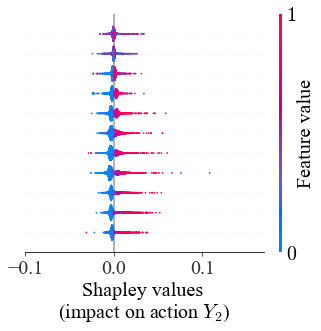

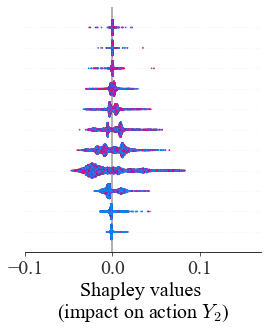

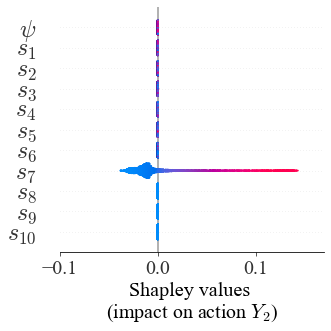

In [75]:
import pickle
import matplotlib.pyplot as plt

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams.update({'font.size': 20})

pids_0_blending = ["spirits_010", "spirits_110", "spirits_000", "spirits_100", "spirits_0100", "spirits_1100", "spirits_0000", "spirits_1000"]

pids = ["spirits_010", "spirits_011", "spirits_012"]
shap_values = {}
for pid in pids:
    if pid in pids_0_blending:
        shap_values[pid] = pickle.load(open(f"C:\\Users\\ga84cib\\Documents\\gitlab\\ameliorating_inventory_drl\\problem_configurations\\{pids_average_blending[pids_0_blending.index(pid)]}\\training_results\\0_blending_p_nn_xy_lp\\shap_values_tree15.pkl", "rb"))
    else:
        shap_values[pid] = pickle.load(open(f"C:\\Users\\ga84cib\\Documents\\gitlab\\ameliorating_inventory_drl\\problem_configurations\\{pid}\\shap_values_tree15.pkl", "rb"))

# 
#create shap summary plot with feature names
pid_avg = "spirits_012"
# shap_values_avg = pickle.load(open(f"C:\\Users\\ga84cib\\Documents\\gitlab\\ameliorating_inventory_drl\\problem_configurations\\shap_values_tree_average.pkl", "rb"))
#print(shap_values[pid_avg][0])

summary_legacy(shap_values[pid_avg][3], test_features[pid_avg], feature_names=feature_names, plot_type="dot", plot_size=(5, 5), show_feature_names=  False, sort=False, show=False)
plt.savefig("C:/Users/ga84cib/Documents/gitlab/ameliorating_inventory_drl/problem_configurations/shap_summary_avg_y2.pdf", dpi=300)
plt.show()

pid_min = "spirits_011"
# shap_values_min = pickle.load(open(f"C:\\Users\\ga84cib\\Documents\\gitlab\\ameliorating_inventory_drl\\problem_configurations\\shap_values_tree_minimum.pkl", "rb"))

summary_legacy(shap_values[pid_min][3], test_features[pid_min], feature_names=feature_names, plot_type="dot",  plot_size=(4.12, 5), color_bar = False, show_feature_names=False, sort=False, show=False)
plt.savefig("C:/Users/ga84cib/Documents/gitlab/ameliorating_inventory_drl/problem_configurations/shap_summary_min_y2.pdf", dpi=300)
plt.show()

pid_0 = "spirits_010"
# shap_values_0 = pickle.load(open(f"C:\\Users\\ga84cib\\Documents\\gitlab\\ameliorating_inventory_drl\\problem_configurations\\shap_values_tree_0.pkl", "rb"))

summary_legacy(shap_values[pid_0][3], test_features[pid_0], feature_names=feature_names, plot_type="dot",  plot_size=(5, 5), sort = False, color_bar=False, show=False)
plt.savefig("C:/Users/ga84cib/Documents/gitlab/ameliorating_inventory_drl/problem_configurations/shap_summary_0_y2.pdf", dpi=300)
plt.show()

In [98]:
pids_high_k = ["spirits_002", "spirits_012", "spirits_0002", "spirits_0102"]
pids_low_k = ["spirits_102", "spirits_112", "spirits_1002", "spirits_1102"]
shap_values_high_k = {}
shap_values_low_k = {}
for pid in pids_high_k:
    shap_values_high_k[pid] = pickle.load(open(f"C:\\Users\\ga84cib\\Documents\\gitlab\\ameliorating_inventory_drl\\problem_configurations\\{pid}\\shap_values_tree15.pkl", "rb"))
for pid in pids_low_k:
    shap_values_low_k[pid] = pickle.load(open(f"C:\\Users\\ga84cib\\Documents\\gitlab\\ameliorating_inventory_drl\\problem_configurations\\{pid}\\shap_values_tree15.pkl", "rb"))


abs_shap_values_high_k = {}
abs_shap_values_low_k = {}

print(len(shap_values_high_k["spirits_012"][0].values[:,0]))

for pid in pids_high_k:
    abs_shap_values_high_k[pid] = np.mean(np.abs(shap_values_high_k[pid][0].values[:,0]))
for pid in pids_low_k:
    abs_shap_values_low_k[pid] = np.mean(np.abs(shap_values_low_k[pid][0].values[:,0]))

print("abs_shap_values_high_k", abs_shap_values_high_k)
print("abs_shap_values_low_k", abs_shap_values_low_k)

5000
abs_shap_values_high_k {'spirits_002': 0.38232307501156776, 'spirits_012': 0.3882891298809468, 'spirits_0002': 0.39679571133602154, 'spirits_0102': 0.4087929862826832}
abs_shap_values_low_k {'spirits_102': 0.3842992667419956, 'spirits_112': 0.37390318923190025, 'spirits_1002': 0.40140427485063135, 'spirits_1102': 0.374496139716498}


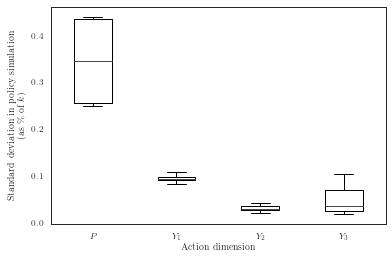

In [88]:
#plot variance of response for different action dimensions (Boxplot across all problem ids)
action_dimensions = ["$P$", "$Y_1$", "$Y_2$", "$Y_3$"]
stds = {i: [np.std(test_labels[pid][i]) for pid in problem_ids] for i in range(4)}
means = {i: [np.mean(test_labels[pid][i]) for pid in problem_ids] for i in range(4)}
covs = {i: [np.std(test_labels[pid][i])/np.mean(test_labels[pid][i]) for pid in problem_ids] for i in range(4)}

#create a plot showing the cov on the y-axis and the action dimensions on the x-axis
import matplotlib.pyplot as plt

plt.boxplot([stds[i] for i in range(4)], labels=action_dimensions)
plt.ylabel("Standard deviation in policy simulation \n (as \% of $k$)")
plt.xlabel("Action dimension")
plt.show()
